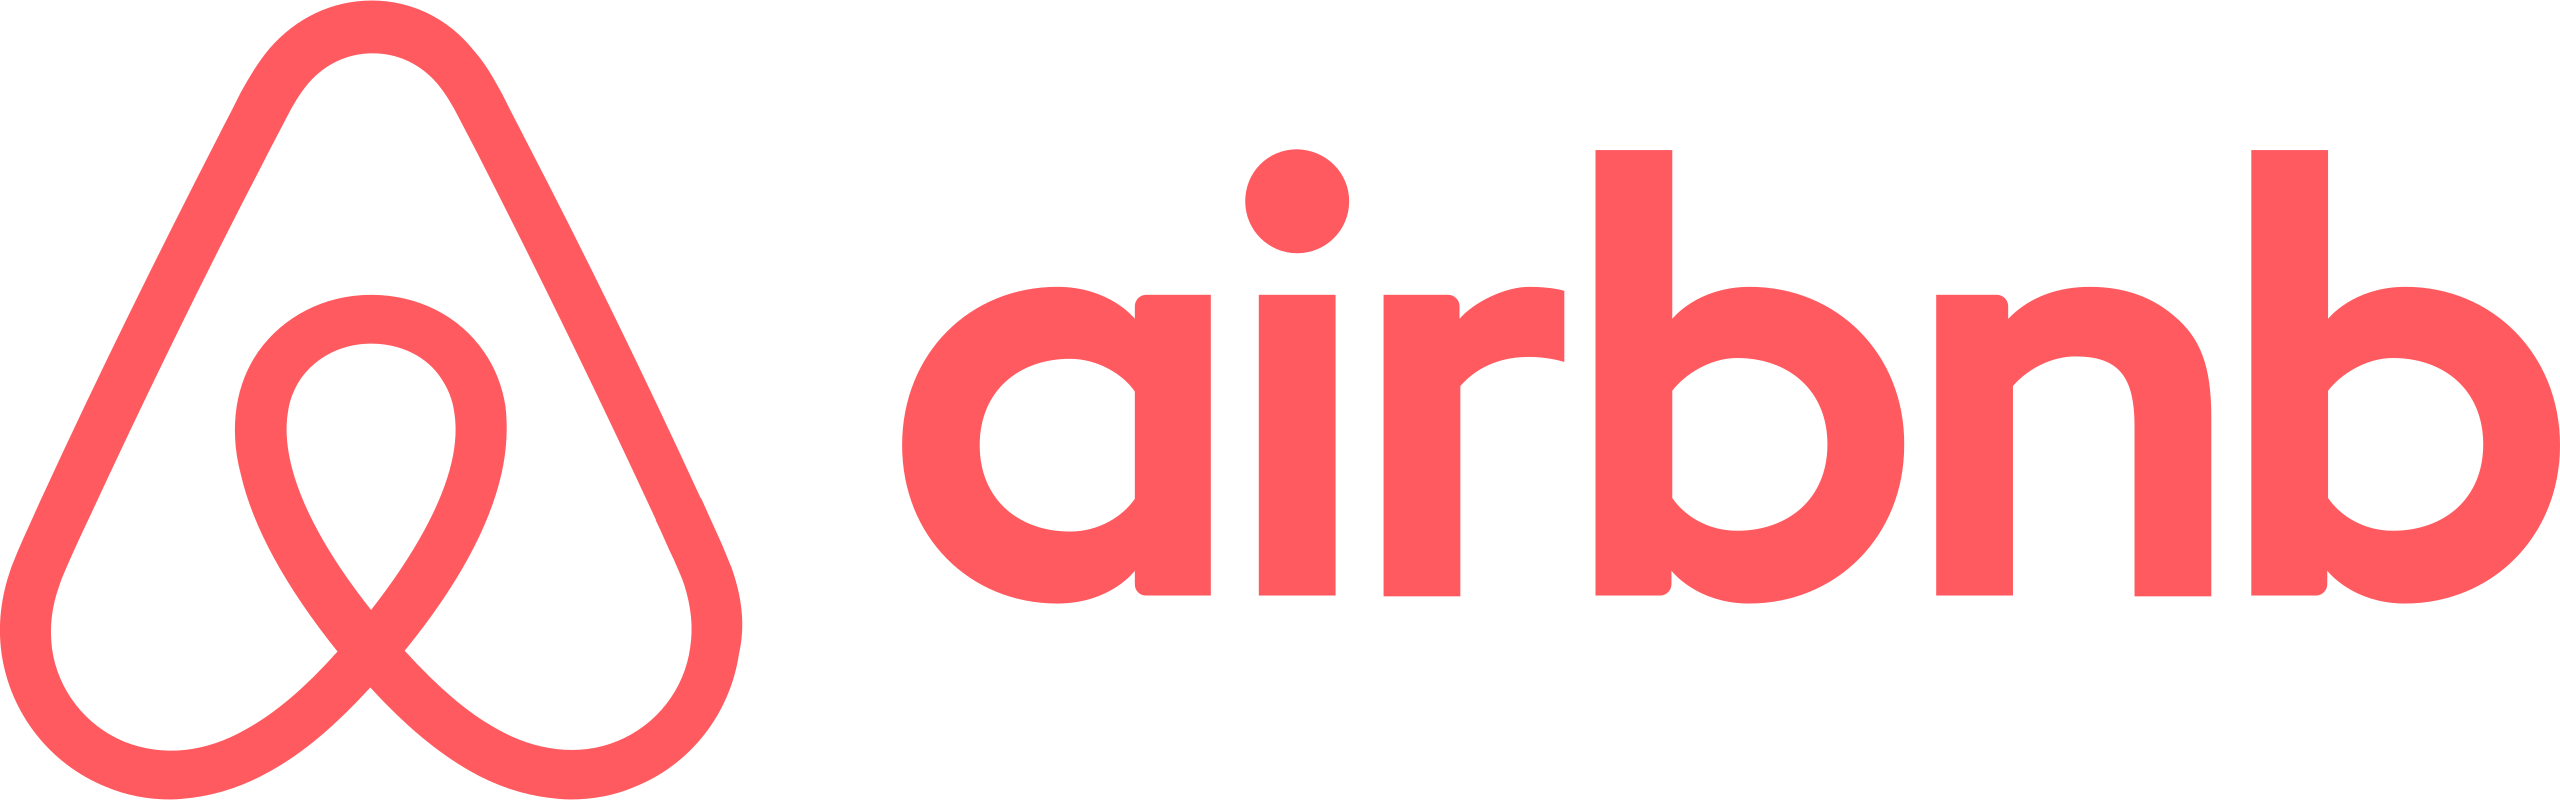

# AirBNB NYC Property Clustering - Final Report

## Springboard Data Science Track - Third Capstone - Travis Martin

### Context
Airbnb is an online vacation rental platform founded in 2008. It has rapidly grown to include over 7 million listings in over 100,000 cities across the globe. All information about these properties is provided by their owners, and there's a robust system of ratings and reviews for both properties and renters.

### Problem Statement:
The purpose of this project is to identify meaningful clusters of Airbnb properties based on more than just their physical location, and to provide Airbnb with recommendations on how to leverage the  resulting clusters. This analysis will use owner-provided features, amenities lists, and text descriptions, along with Natural Language Processing and an unsupervised clustering model (KMeans) to group similar properties.


### Dataset and Scope
The original dataset, which came from a Kaggle competition based on predicting listing prices, contained approximately 74K rows, and 29 feature columns.

In its base form, the dataset contained information on Airbnb rental properties in 6 large US cities (NYC, LA, SF, Chicago, DC, and Boston). In order to limit the scope of the modeling, and hopefully create more meaningful clusters, I chose to restrict my focus to only properties in the NYC area. Further, since comparisons between full-property rentals and rentals of only a single private or shared room within a larger property would likely not be valid, I also filtered the data to include only "entire home/apt" rentals. This brought the number of properties under consideration to 16,243.

### Stakeholders
For the purpose of this analysis, I proceeeded as though I had been contracted by Airbnb themselves to identify usable property clusters and provide recommendations on how to leverage the clusters' unique feature-set.

## Data Wrangling
After loading the dataset, I began by exploring its columns and their associated data types.

### "Base" Columns - Columns requiring no or minimal reformatting
- id - Unique property identifier - Float
- log_price - Natural Log of the average USD nightly rental price - Float
- property_type - Ranges from apartment to houseboat to yurt - String
- room_type - Indicates whether rental is a full property or single room. As mentioned above, I chose to restrict this to full properties only - String
- accommodates - # of persons accommodated by the property - Float
- bathrooms - # of full and half bathrooms in the rental - Float
- bed_type - Primarily "real bed" with a mix of couch, futon, airbed, etc. - String
- cancellation_policy - Strict/Moderate/Flexible categorical variable - String
- cleaning_fee - True/False indicator of an additional cleaning fee - String
- city - One of 6 major US cities, but limited to NYC for this analysis - String
- first_review - Calendar date of the first review the rental received - String
- host_has_profile_pic - True/False indicator of host having a photo associated with their user profile - String
- host_identity_verified - True/False indicator of host having their identity verified by Airbnb - String
- host_response_rate - Range between 0 and 100% indicating % of messages that the host has responded to - String
- host_since - Calendar date indicating when the host joined the service and listed their first rental - String
- instant_bookable - True/False indicator of whether a user can book directly without first inquiring availability from the host - String
- last_review - Calendar date of most recent review of the rental - String
- latitude - Approximate Latitude coordinate of rental - Float
- longitude - Approximate Longitude coordinate of rental - Float
- neighborhood - Neighbourhood containing the rental (ownder provided) - String
- number_of_reviews - Total number of reviews submitted for the property - Float
- review_scores_rating - Range between 0 and 100 indicating the average user rating of the property - Float
- thumbnail_url - Web address (if exists) of photo thumbnail of the rental - String
- zipcode - US Postal Code for the rental - String
- bedrooms - Number of bedrooms on the property - Float
- beds - Number of beds on the property - Float

#### Null-values and formatting issues addressed:
- bathrooms - identified "0.0" or "NaN" bathroom listings and scanned their description text. Of the 21 missing values, only 2 confirm that there is no bathroom on site. The associated property types (1 houseboat and 1 garage apartment) were not representative and were dropped. 86% of total listings contain 1.0 bathrooms, so the remaining 19 missing values were assigned this value.
- first_review - Converted from string to Datetime column. Created a 'today' datetime variable 1 day after the max value of the 'last_review' column. Assigned this value to all nulls in the first_review column. Created a new 'days_since_first_review' column that calculated the timedelta between 'today' and 'first_review' in days. first_review column dropped.
- host_has_profile_pic - 80 null values, reassigned to "False". Column converted from string to boolean.
- host_identity_verified - 80 null values, reassigned to "False". Column converted from string to boolean.
- host_response_rate - ~5k nulls, replaced with average of non-null records.
- host_since - Converted from string to Datetime column. Assigned this value to all nulls in the host_since column. Created a new 'days_since_host_start' column that calculated the timedelta between 'today' and 'host_since' in days. host_since column dropped.
- neighbourhood - had as many unique records as zipcode, making it redundant. Column dropped.
- review_scores_rating - ~500 nulls, replaced with average of non-null records.
- thumbnail_url - converted into a boolean column 'has_url'
- zipcode - Used reverse geocoding (GeoPy) to populate missing values (and replace improperly coded zips) based on lat/lon coordinates.
- beds - Only 10 nulls. Assumed 1:1 bedroom:bed relationship and copied over value from bedrooms 'column'.

#### Other Data-Wrangling Steps
- Used zip code lists found online to create a new column assigning each property to its corresponding NYC borough (Manhattan, Brooklyn, Bronx, Queens, or Staten Island)


### "Amenities" column 
amenities - Total collection of features and amenities for the property, as selected by owners from a pre-determined list provided by the platform. Stored as a dictionary of strings, 1 per property.

There were a total of 116 unique amenities (and one 'blank') present in the dataset. To make the analysis more targeted and reduce dimensionality, I assigned each amenity to one of three basic categories. I leveraged the first group and ignored the other two.

**Targets** - Amenities which could presumably affect clustering behavior and are also present in sufficient numbers in the source data.
   - Wireless Internet / Internet
   - Air conditioning
   - Laptop friendly workspace
   - Family/kid friendly
   - Washer / Dryer / 'Washer / Dryer'
   - Elevator
   - 24-hour check-in
   - Lock on bedroom door
   - Self Check-In
   - Pets allowed
   - Doorman
   - Private entrance
   - Stove
   - Oven
   - Gym
   - Lockbox
   - Free parking on premises / Free parking on street
   - Breakfast
   - Wheelchair accessible
   - Bathtub
   - Pets live on this property
   - Suitable for events
   - Indoor fireplace
   - Dishwasher
   - Hot tub
   - Long term stays allowed
   - Room-darkening shades
   - Dog(s) / Cat(s) / Other pet(s)
   - Luggage dropoff allowed
   - Smoking allowed
   - Keypad
   - Patio or balcony
   - Garden or backyard
   - Private living room
   - Pool
   - Smart lock
   - BBQ grill
   - Crib / High chair / Pack â€™n Play/travel crib


**"Givens"** - Amenities which are either considered a given in a short-term rental (e.g. Smoke Detector, Shampoo), or are small enough "nice to have" upgrades that they will likely not measurably impact clustering behavior (e.g. First aid kit, Outlet covers)
   - Kitchen
   - Heating
   - Essentials
   - Smoke detector
   - TV
   - Shampoo
   - Carbon monoxide detector
   - Hangers
   - Hair dryer
   - Iron
   - Buzzer/wireless intercom
   - Cable TV
   - Fire extinguisher
   - First aid kit
   - translation missing: en.hosting_amenity_50
   - translation missing: en.hosting_amenity_49
   - Safety card
   - Refrigerator
   - Dishes and silverware
   - Cooking basics
   - Hot water
   - Bed linens
   - Microwave
   - Coffee maker
   - Extra pillows and blankets
   - Host greets you
   - Children's books and toys
   - Step-free access
   - Window guards
   - Well-lit path to entrance
   - Ethernet connection
   - Babysitter recommendations
   - Single level home
   - Wide doorway
   - Children's dinnerware
   - Wide hallway clearance
   - Wide clearance to bed
   - Smooth pathway to front door
   - Flat
   - Outlet covers
   - Accessible-height bed
   - Wide entryway
   - Accessible-height toilet
   - Baby bath
   - Other
   - Pocket wifi
   - Changing table
   - Stair gates
   - Hot water kettle
   - Firm mattress
   - Wide clearance to shower & toilet
   - Handheld shower head
   - Fireplace guards
   - Baby monitor
   - Table corner guards
   - Fixed grab bars for shower & toilet
   - Bathtub with shower chair

**Exclusions** - Amenities which could potentially drive clustering behavior, but are extremely low in number (e.g. EV Charger) or inappropriate for the NYC market (e.g. Ski in/Ski out).
   - Game console
   - Cleaning before checkout
   - Waterfront
   - Beach essentials
   - EV charger
   - Ground floor access
   - Disabled parking spot
   - Beachfront
   - Air purifier
   - Lake access
   - Private bathroom
   - Ski in/Ski out
   - Roll-in shower with chair
   
I then took the 38 'target' amenities, and created a dummy-variable-style 1/0 column for each based on whether that amenity appears in each rentals 'amenities' dictionary.

I also created a new column with the number of amenities listed for each rental.

### "Text" columns (NLP)
description and name - The owner-generated property descriptions and property names. Entered as free-form text governed only by a character limit (and perhaps a content filter). Each stored as a string.

I performed Natural Language processing on these two columns using the nltk Python library. The general process followed for 'description' and repeated for 'name' was:
- Converting all characters to lower-case only
- Tokenize the column, creating a new column where each row contains a list with every word in the description as a separate string.
- Lemmatize the tokenized word lists, replacing all forms of a given word with its root word (ex: rides/riding/rode -> ride)
- Filtering for "stop words" - Base English stop words dictionary includes words like "the", "and", "of", which are extremely common and don't add to the meaning of a sentence. To this, I added filters for common characters like "&" and "...", which the tokenizer treats as words.
- Creating a new column for word count of the filtered descriptions/names
- Calculate and plot word frequencies using a flattened list of all words in all descriptions.

Then, using the word frequency list and my own knowledge, I created 24 new word groupings based on similar meanings or sentiments.

- "Big" words - Words associated with a property's largeness. Ex: "spacious", "roomy", "wide"
- "Small" words - Similar to above, but for small spaces. Ex: "cozy", "narrow", "minimalist"
- "Public transit" words - Words related to public transportation. Ex: "subway", "station", "buses"
- "Landmark" words - Referring to a specific landmark or well-known attraction in the city. Ex: "MOMA", "empire", "Chinatown"
- "Nightlife" words - Words related to nightlife activities. Ex: "bars", "restaurants", "comedy"
- "Business" words - Any words related to offices or remote-work. Ex: "desk", "laptop", "printer"
- "Safety" words - Words having to do with safety or security. Ex: "alarm", "safe", "secure"
- "View" words - Words relating to the quality of the view out the window. Ex: "overlook", "panorama", "picturesque"
- "Updated" words - Words associated with home improvements or renovations. Ex: "restored", "upgraded", "remodeled"
- "Cleanliness" words - Words around cleanliless and organization. Ex: "pristine", "uncluttered", "immaculate"
- "Tourism" words - Words related to leisure travel and sightseeing. Ex: "getaway", "tours", "attractions"
- "Relaxation" words - Words associated with a relaxing atmosphere. Ex: "oasis", "soothing", "quiet"
- "Family" words - Words denoting the child-friendliness of a property. Ex: "family-friendly", "child-proof", "toys"
- "Proximity" words - Words relating to how nearby a property is to points of interest. Ex: "walkable", "blocks", "minutes"
- "Romance" words - Words associated with love and couples. Ex: "romantic", "anniversary", "couples"
- "Luxury" words - Words implying a property has high-end finishes. Ex: "luxurious", "high-end", "designer"
- "Culture" words - Words relating to arts and culture. Ex: "cultural", "galleries", "community"
- "Ease" words - Words connoting ease and simplicity. Ex: "convenient", "accessible", "automatically"
- "Hip" words - Words associated with youth and popular culture. Ex: "hipster", "stylish", "trendiest"
- "History" words - Refer to the historical nature of a property or its surroundings. Ex: "Pre-war", "classical", "original"
- "Nature" words - Words associated with nature and outdoor spaces. Ex: "parkside", "tree-lined, "greenery"
- "Retail" words - Words and names associated with retail shopping. Ex: "CVS", "supermarket", "boutiques"
- "Negative" words - Words with a negative connotation. Ex: "filthy", "cramped", "chaotic"

I populated each of these lists with words from the descriptions (and variations thereof), and even added synonyms not included so as to start building a knowledge-base independent of this specific dataset.

I was then able to create new columns counting how frequently words from the group lists appeared in each listing's description (24 new columns in total).

## Exploratory Data Analysis
I performed Exploratory Data Analysis using a combination of Python and Tableau to uncover column relationships and distributions.

#### "Base" Columns

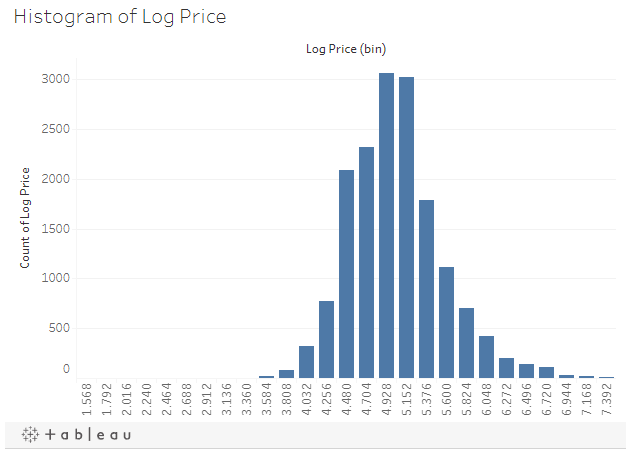

Log price shows a fairly symmetric distribution, but with long tails in both directions. Prices are mostly clustered between 4.4 (82USD) and 5.6 (270USD), with a mean near 5.0 (~148USD per night).

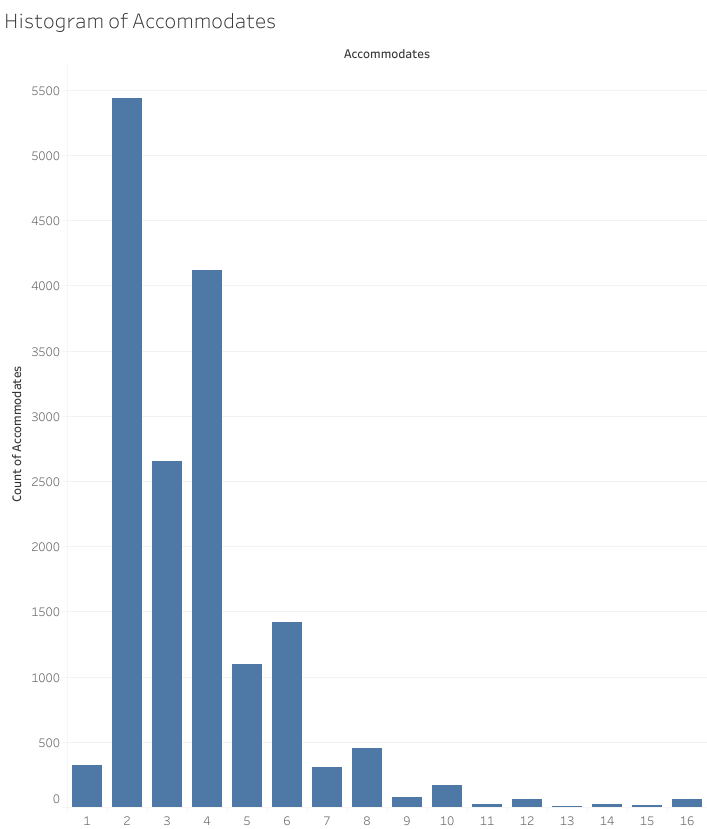

The vast majority of properties accommodate between 2 and 4, but the distribution also has a long-sloping right tail that reaches to 16.

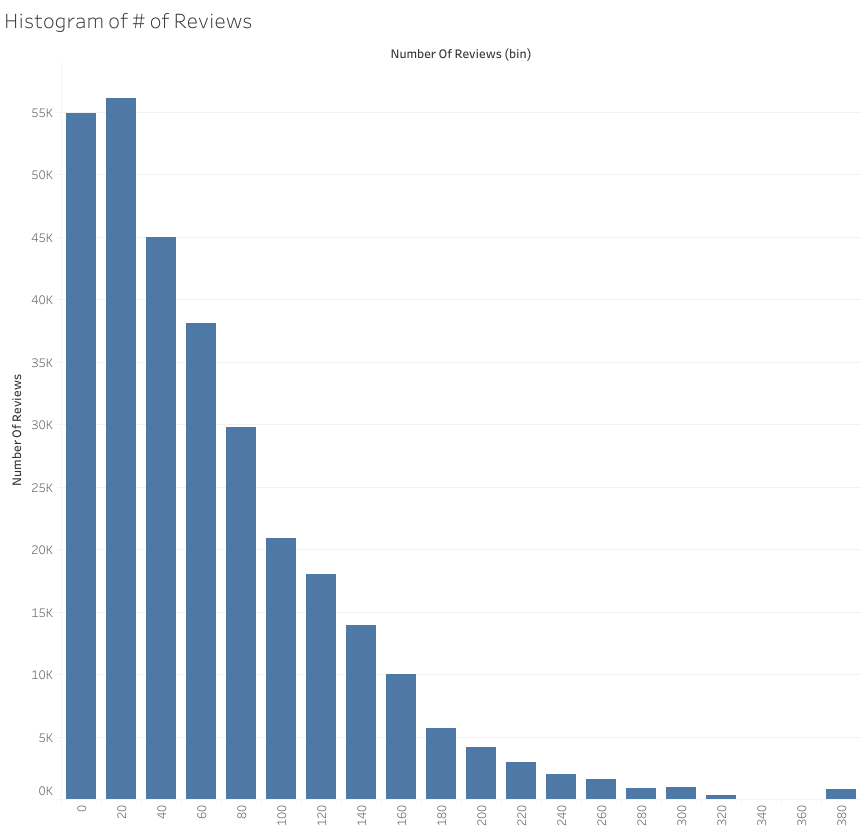

Most properties have between 0 and 40 reviews, but the range extends to over 380.

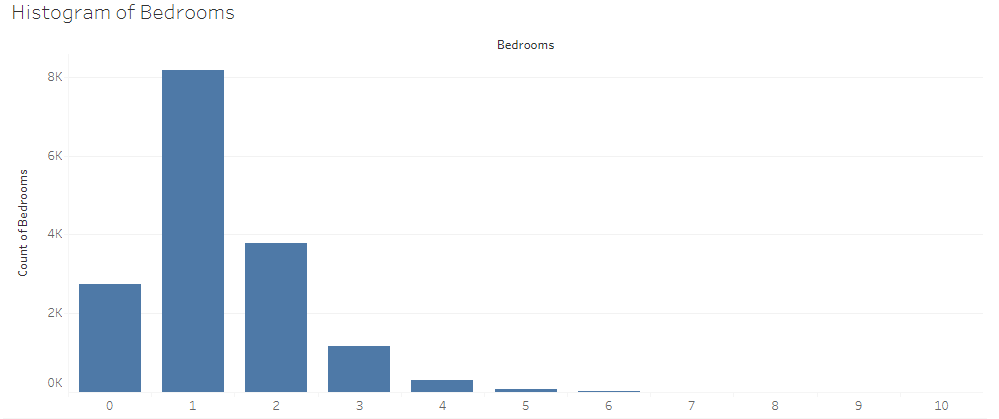

Most properties are 1-bedroom or 2-bedroom, followed by 0-bedroom (loft or equivalent).

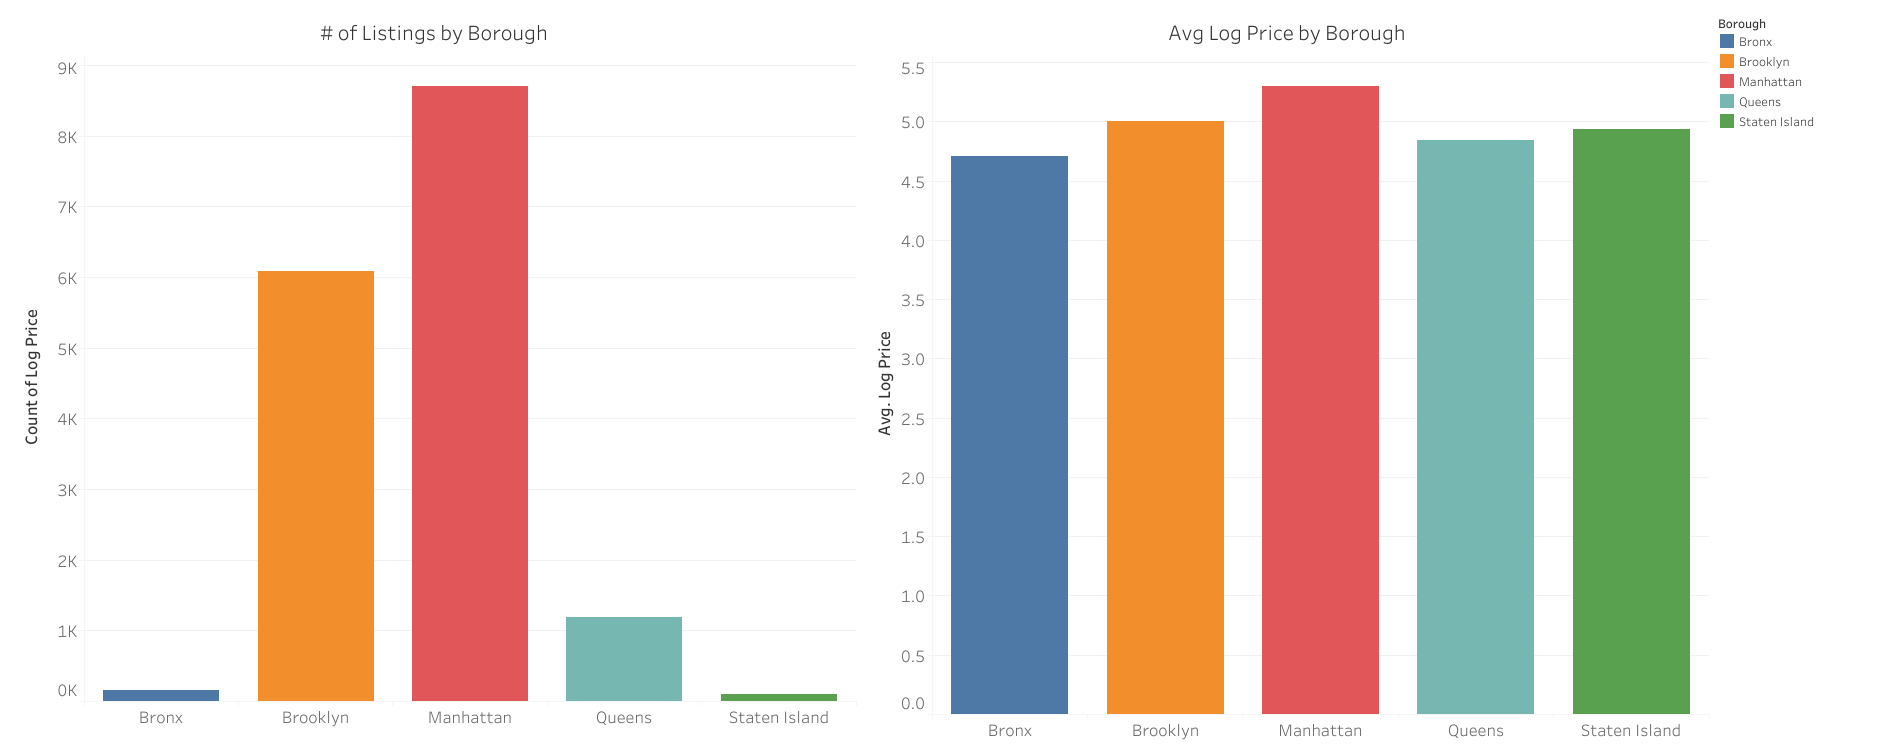

Manhattan boasts the highest number of properties in the dataset, followed by Brooklyn. Queens, Bronx, and Staten Island lag far behind.

Manhattan properties tend to be the most expensive as well, followed by Brooklyn. Bronx listings are the cheapest on average.

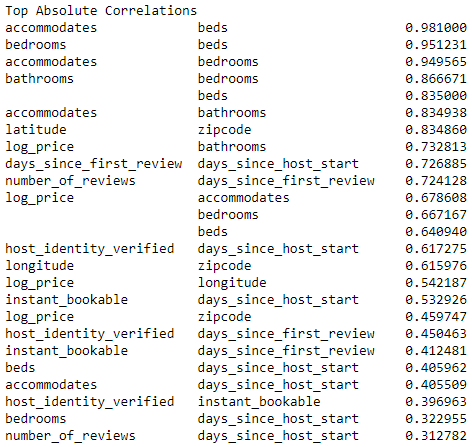

Most of the top correlation pairs revolve around the # accommodated and the # of beds, bedrooms, and bathrooms, which makes good sense.

We also see that log_price is correlated somewhat strongly with Latitude and Longitude, as well as with # of bedrooms and bathrooms.

#### "Amenities" Columns

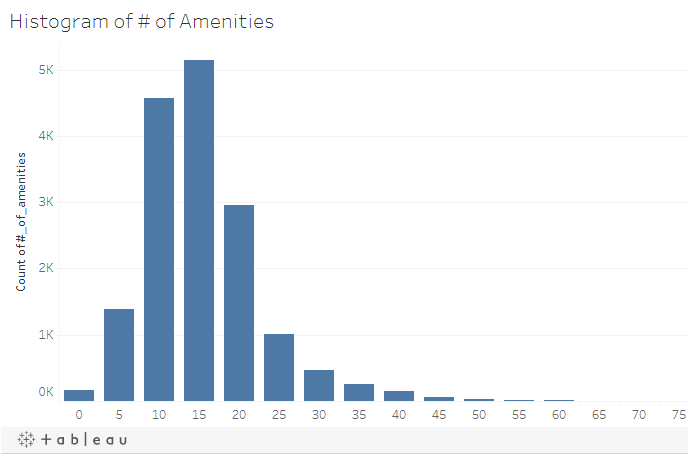

Most owners selected between 5 and 25 amenities for their listings, but the distribution stretches all the way to 75+. 

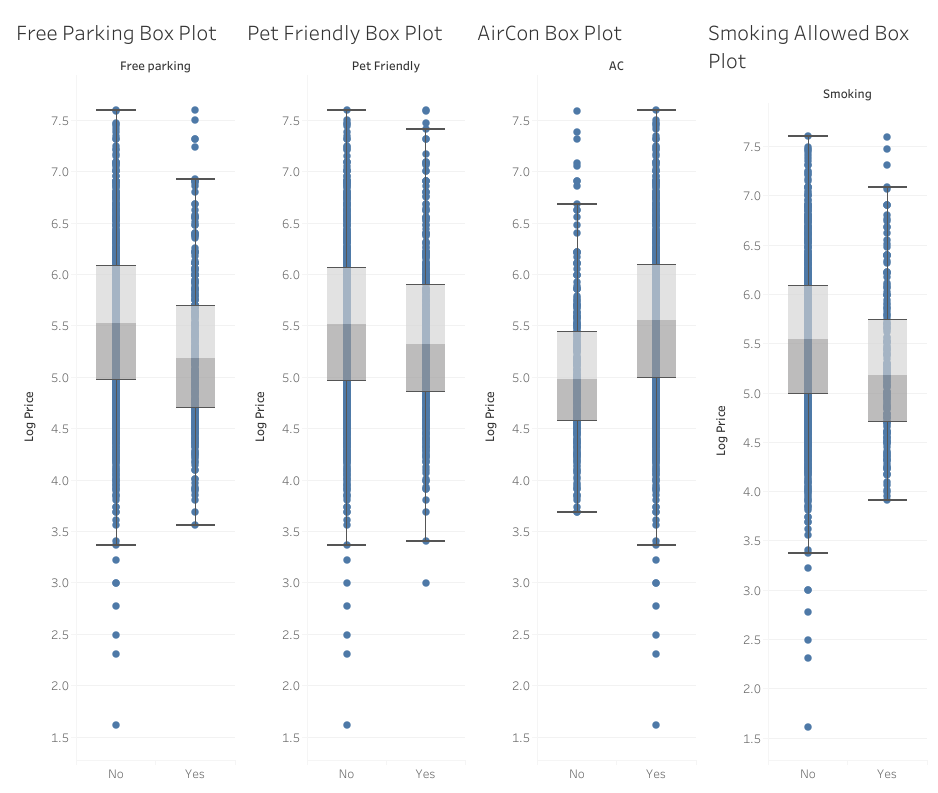

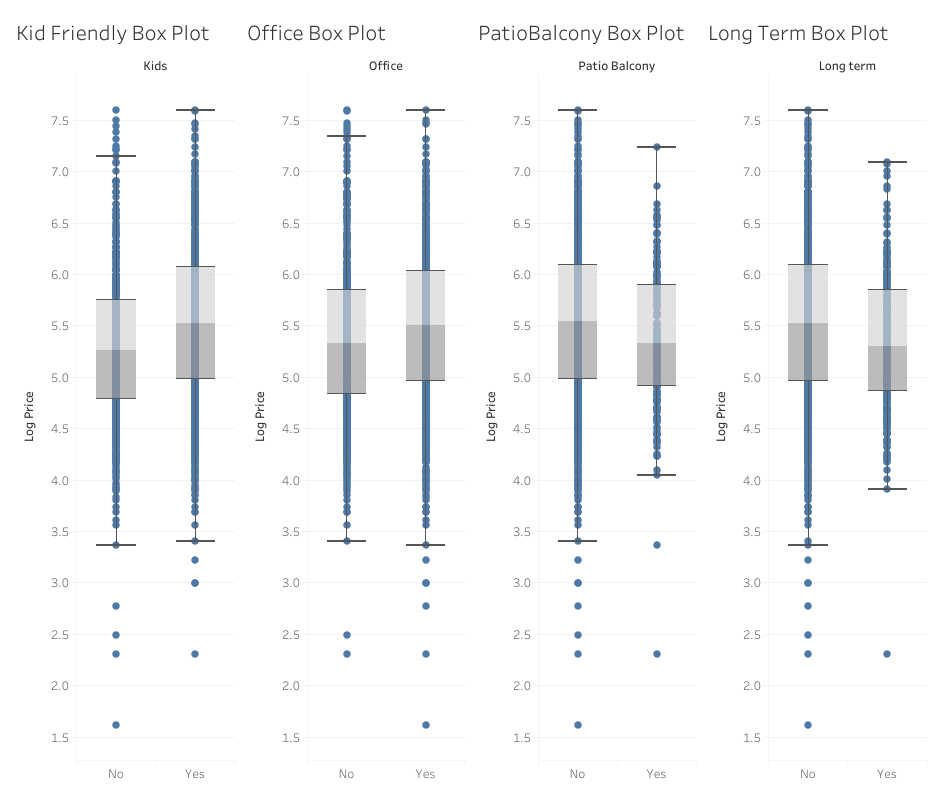

Some of our binary amenity features seem to have a measurable impact on log price, at least as it relates to their IQR. The relationship can be additive, as with Office, Kid-Friendly, and Air Conditioning, or subtractive, as with Smoking Allowed, Free Parking, and Long-Term.

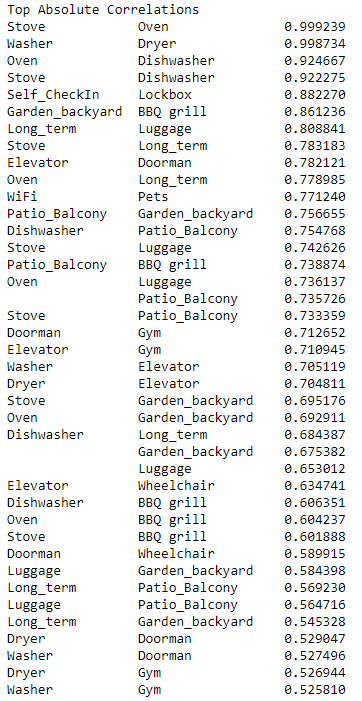

Again, there are some groupings here that make intuitive sense, with Stove+Oven and Washer+Dryer right at the top.

Other notable pairs include:
- Elevator + Wheelchair
- Luggage + Longterm
- Patio/Balcony + Grill
- Doorman + Gym
- Self-CheckIn + Keypad

#### "Text" Columns

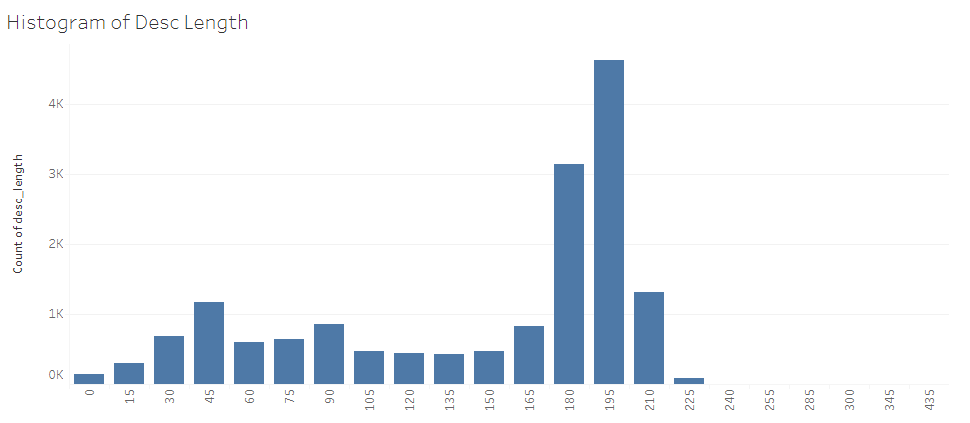

This distribution looks to be governed by the character limit for rental descriptions, as the bulk of the properties are clustered between 165 and 210 words and then sharply drop off around 225. The distribution between 0 and 165 words is rather flat.

The Lat/lon coordinates and zip codes contained in this dataset allow us to do some useful map-based visualizations through Tableau.

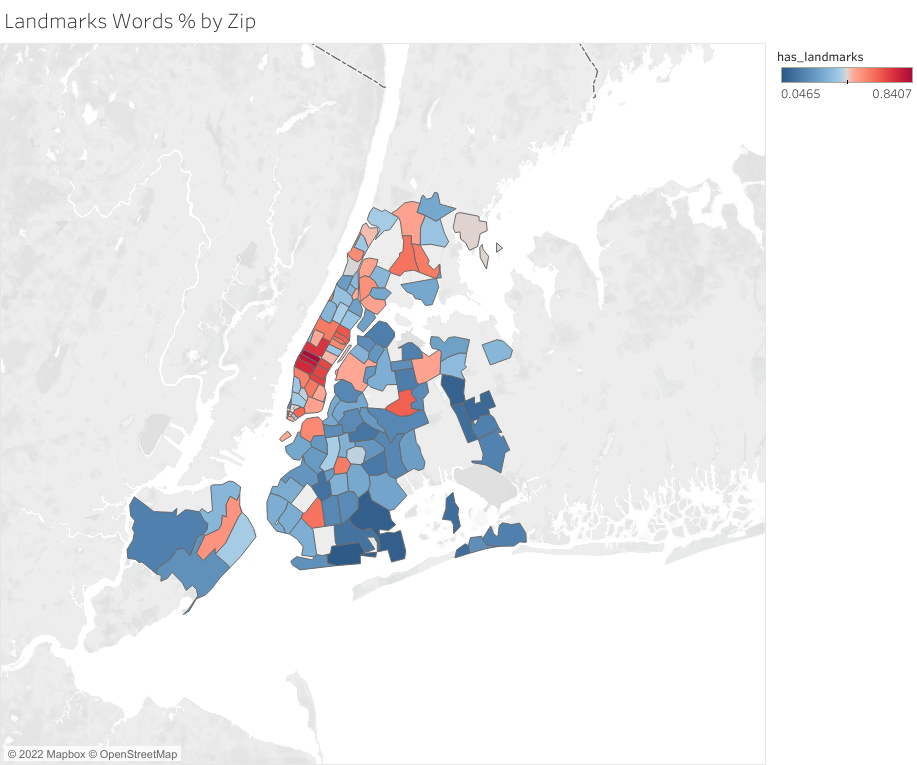

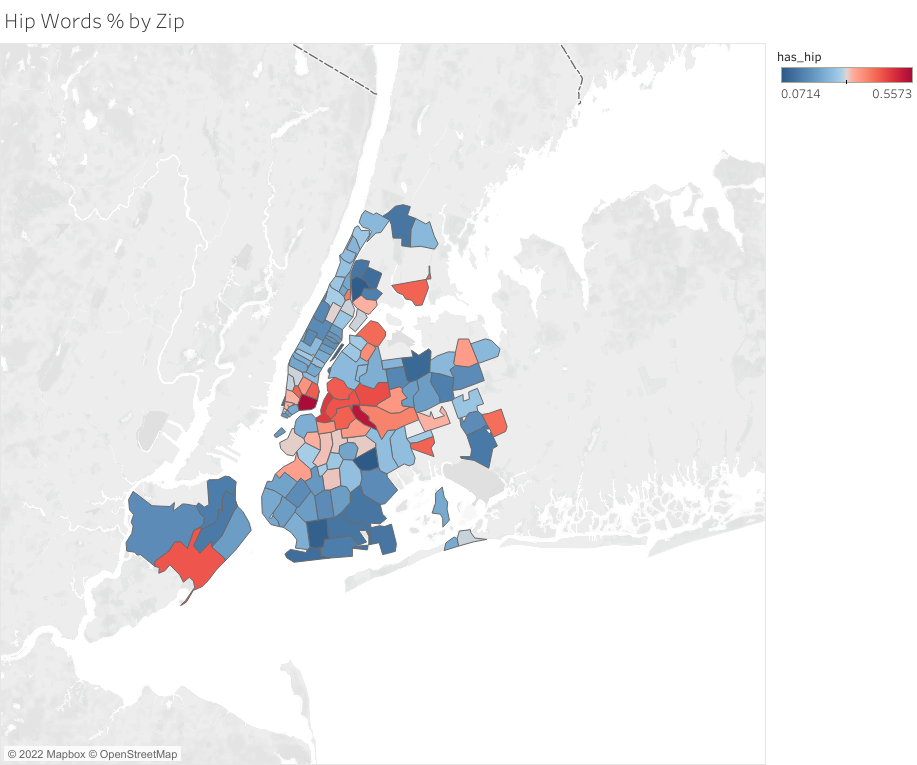

These two maps show the percentage of listing descriptions in each zip containing one or more instances of one of our word groups. 

We can see that midtown and lower Manhattan (in dark pinks and reds), which are home to the Empire State Building, Times Square, and Chinatown, tend to have the highest proportion of properties with descriptions containing "landmark" words.

Brooklyn on the other hand, especially in the trendy Williamsburg area, tends to have the highest proportion of properties with descriptions containing "hip" words.

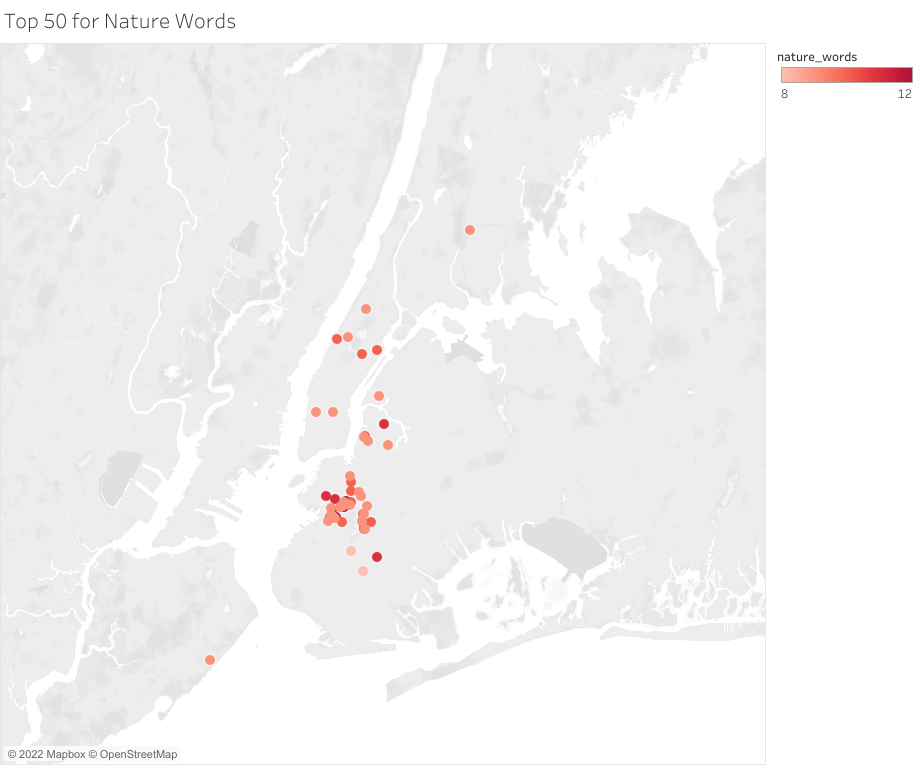

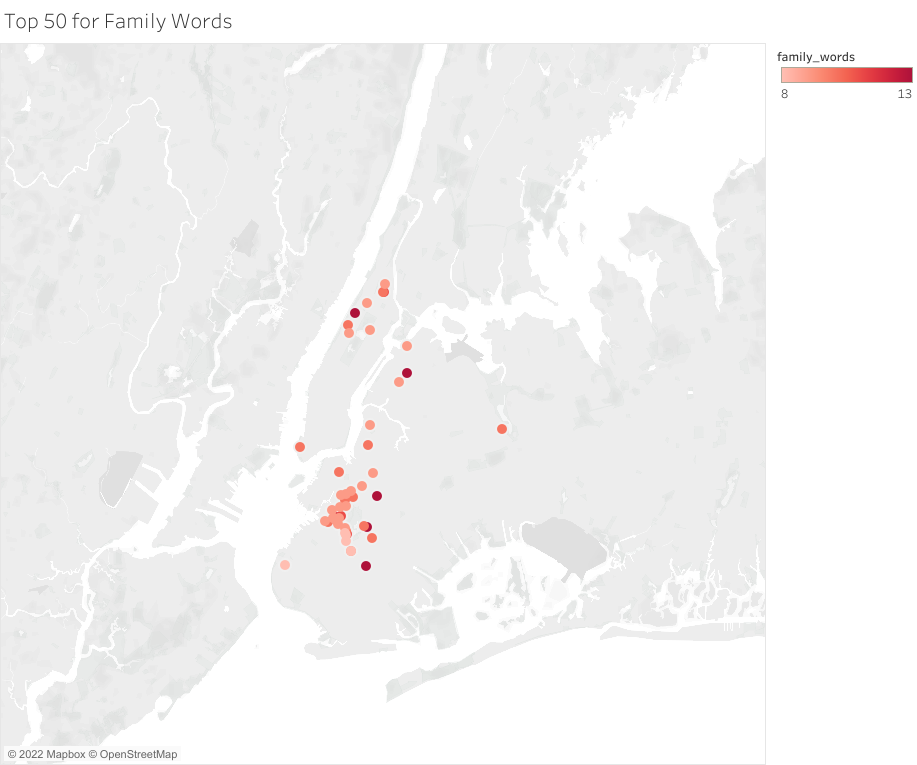

Instead of focusing on zip codes, these maps show the approximate locations of the 50 properties with the highest number of instances of group words in their descriptions, giving a different view of the geographic distribution.

In this case the results are somewhat similar (as they are related to the two word categories with the highest correlation), with "nature" and "family" words both being most emphasized outside of the hustle and bustle of lower and midtown Manhattan. The primary difference is the small handful of "nature" properties that border Central Park.

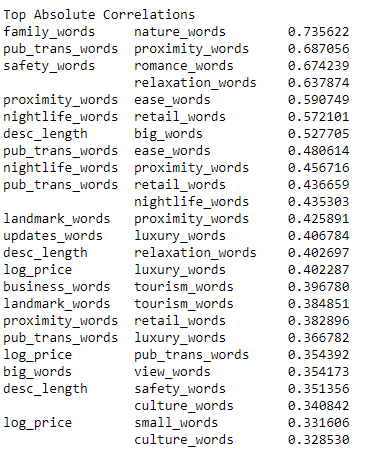

These correlations imply some common-sense overlapping relationships between our various word buckets.
Some examples:
- family_words and nature_words
- safety_words and relaxation_words
- nightlife_words and retail_words
- landmark_words and proximity_words
- updates_words and luxury_words

## Preprocessing

Preprocessing in preparation for unsupervised clustering with KMeans for this dataset involved the following actions:
- Dropping unneeded columns like "neighbourhood" (redundant with zipcode) and "id" (unique identifier unnecessary for prediction)
- Trimming down "property_type" entries to just the top 6 most common (Apartment, House, Loft, Townhouse, Condominium, and Other). This involved re-casting rare types like "cabin", "yurt" and "villa" to "Other".
- Converting 'bed_type', a categorical column with 5 categories to a simple 'real_bed' 0/1 column. (Real bed accounted for over 98% of records)
- Re-classing the 10 properties with "super_strict_30" or "super_strict_60" as their cancellation policy to simply "strict", cutting out the need for 2 dummy columns.

After this process was complete, I was left with a total of 94 numerical feature columns ready for the model.

## Modeling
The first step involved in feeding our KMeans Clustering model was to scale our data so that features with wider ranges wouldn't be over-considered.

In addition, I felt that 94 features might be excessive given some of the high correlations between them, so I chose to run Principal Component Analysis on the dataset for feature reduction. 

I ran both of these processes in parallel using a Pipeline object. I chose the optimal number of features using a chart of # of components vs. Cumulative Variance Explained (shown below) in combination with the "KneeLocator" function found in the kneed library. This revealed that diminishing returns for adding features occurred when they reached 25.

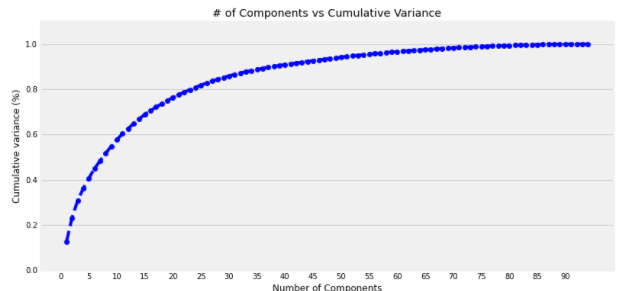

I then created a for loop that iterated through a range of 1 to 20 as the target number of clusters, fit the model to the data, and plotted the results against the Sum of Squared Errors for each number of clusters (below). Again, I leveraged the kneed KneeLocator, and determined that the optimal number of clusters was 5.

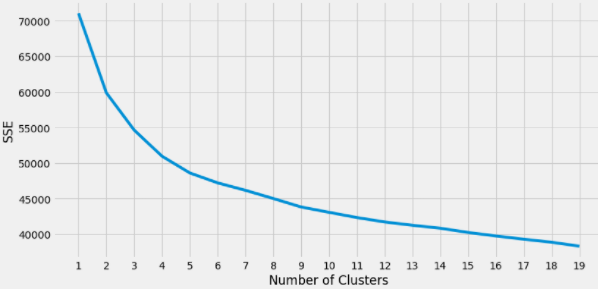

All that remained at that point was to fit the model to the data using the optimal parameters, which would return the cluster labels. I was then able to assign the labels as a new column to the original dataset.

The distribution of properties between the new clusters was as follows:
- Cluster 0 -  4279
- Cluster 1 -  4734
- Cluster 2 -  2479
- Cluster 3 -  1279
- Cluster 4 -  3471

The silhouette score, which is an indicator of intra-cluster density and inter-cluster separatedness, was 0.152 for clustering model. With a scale of possible values between -1 and 1, this was an acceptably positive result. 

## Results Interpretation
In order to fully evaluate the clustering results, I needed to be able to understand which features factored most heavily in the cluster assignment. PCA "anonymized" the feature names by creating Principal Components that were linear combinations of features, but luckily the PCA library also has built-in functionality to get back to a list of feature importances. This process leverages pca.components_, which returns a list of lists where each inner list represents one of the 25 principal components, and each inner list item represents the weighting coefficient for that feature (94 overall), as well as pca.explained_variance_ratio, which returns a list containing the amount of variance explained by each of the 25 principal components.

By performing matrix multiplication on these two lists, and mapping to a list of feature names, I was able to produce a sorted list of feature names and relative importances (below). 

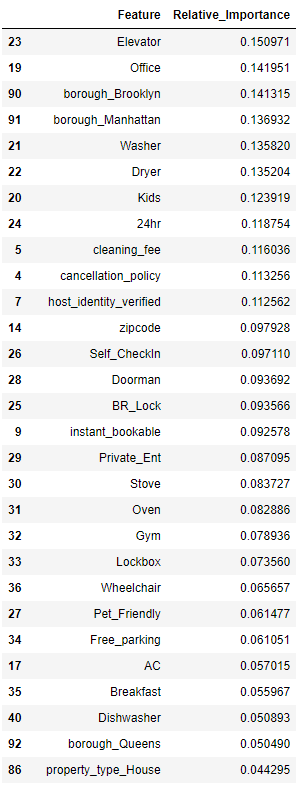

This list can provide some insights, but it can't paint a clear picture of what the defining characteristics were for each cluster. To remedy this, I began a second round of EDA, this time with cluster labels attached. I won't show all of them, but I compared every base, amenity, and text feature across clusters and determined which ones seemed to drive cluster membership. Some visualizations of note for each category:

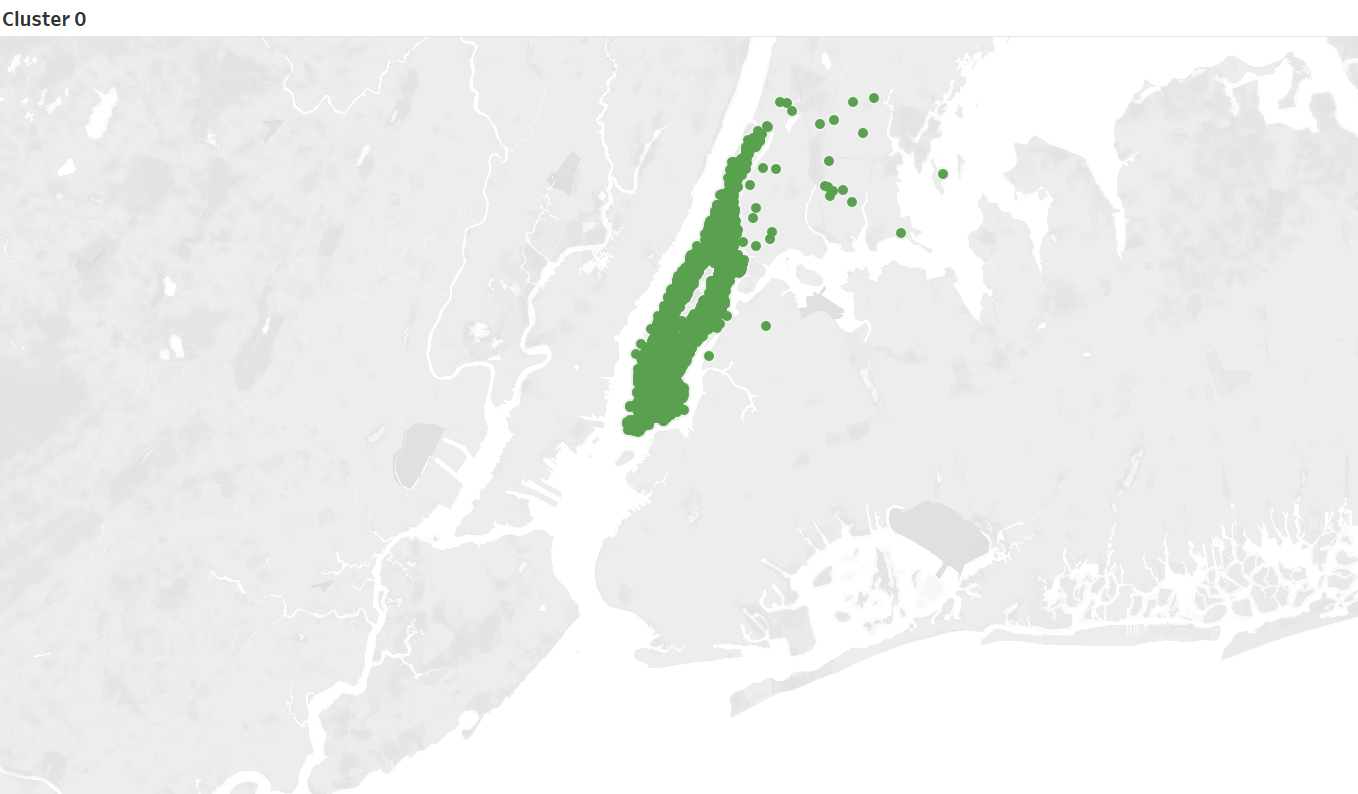

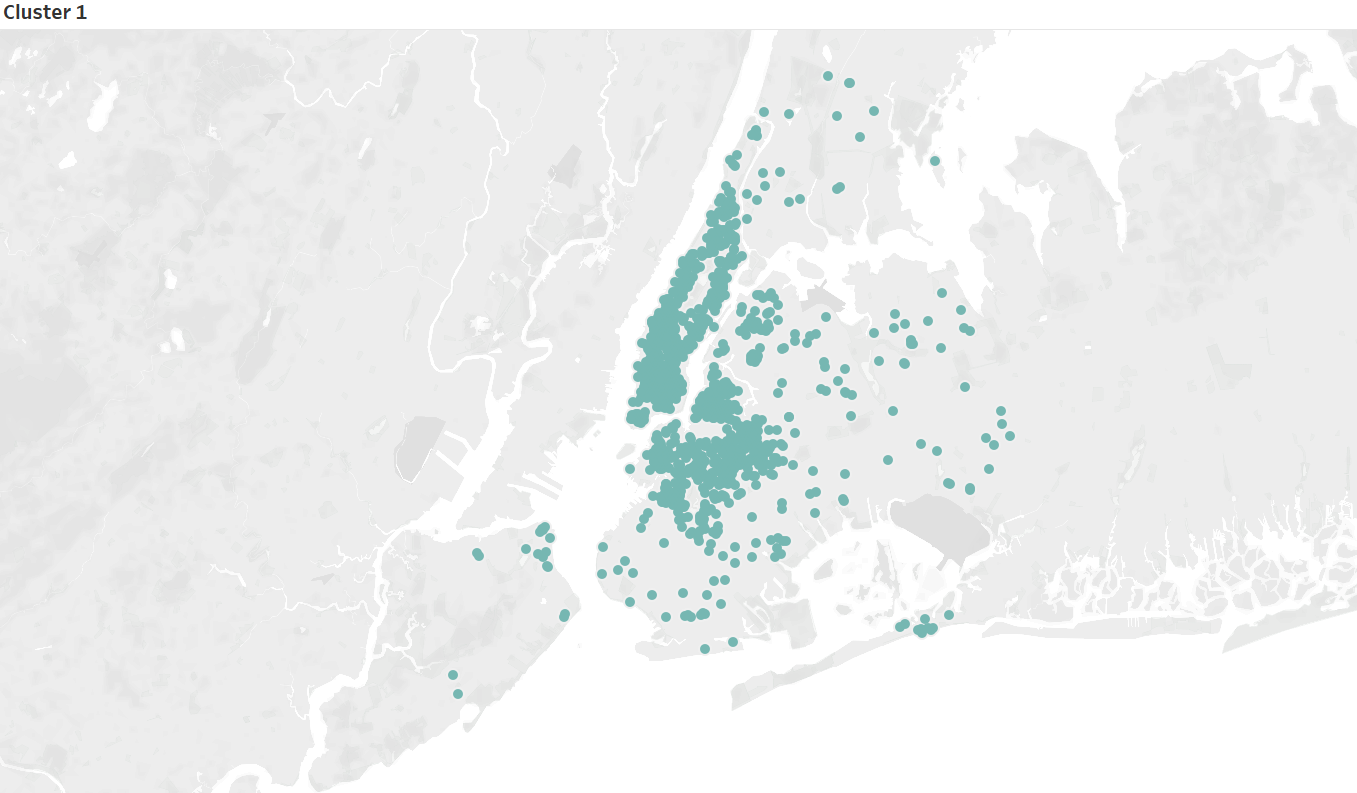

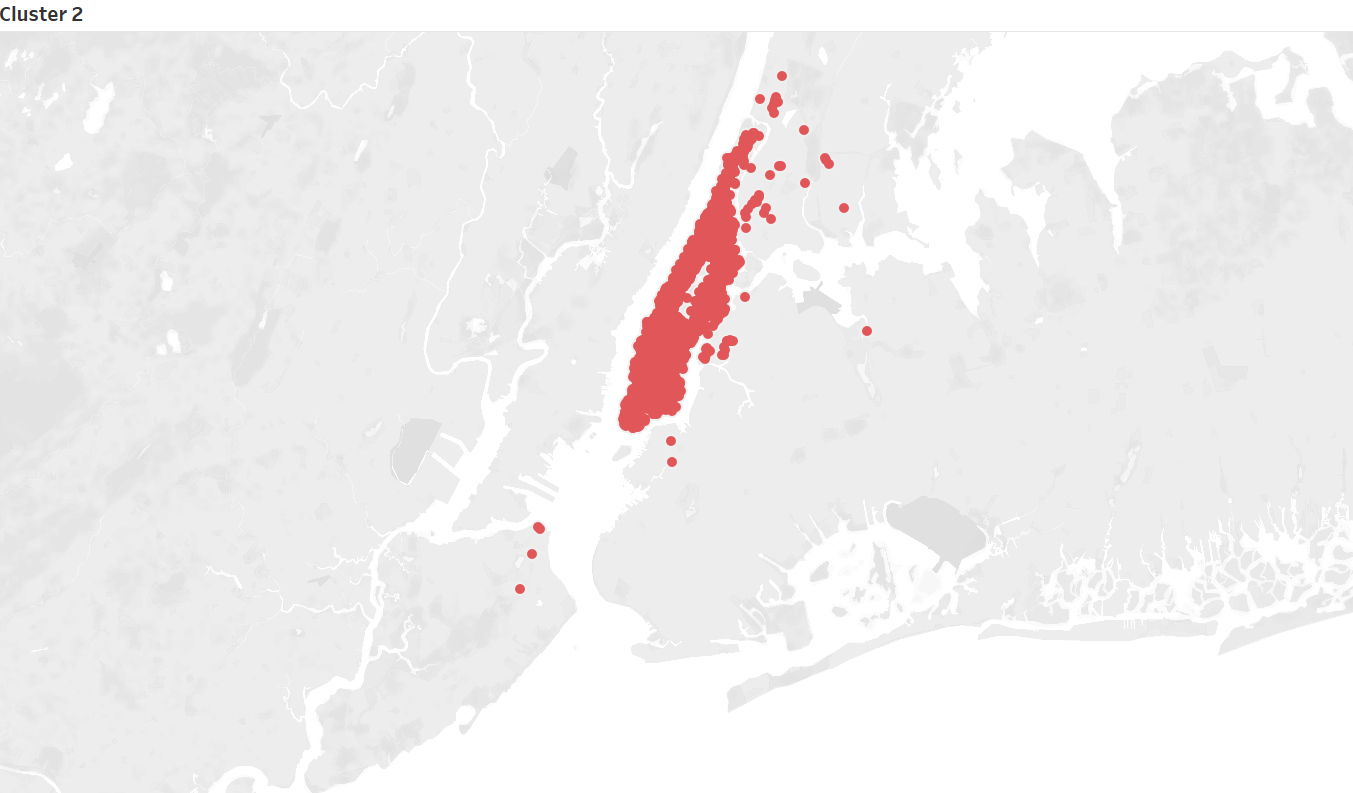

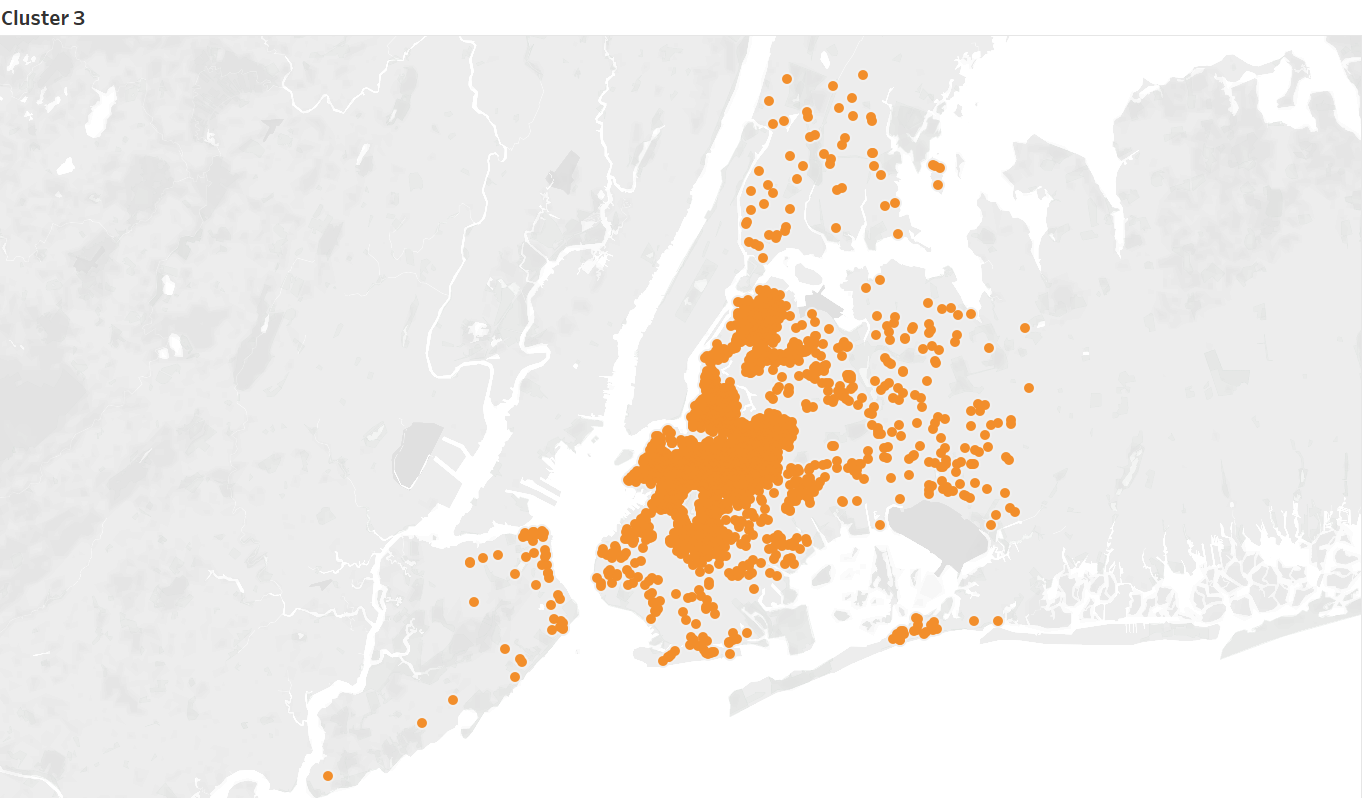

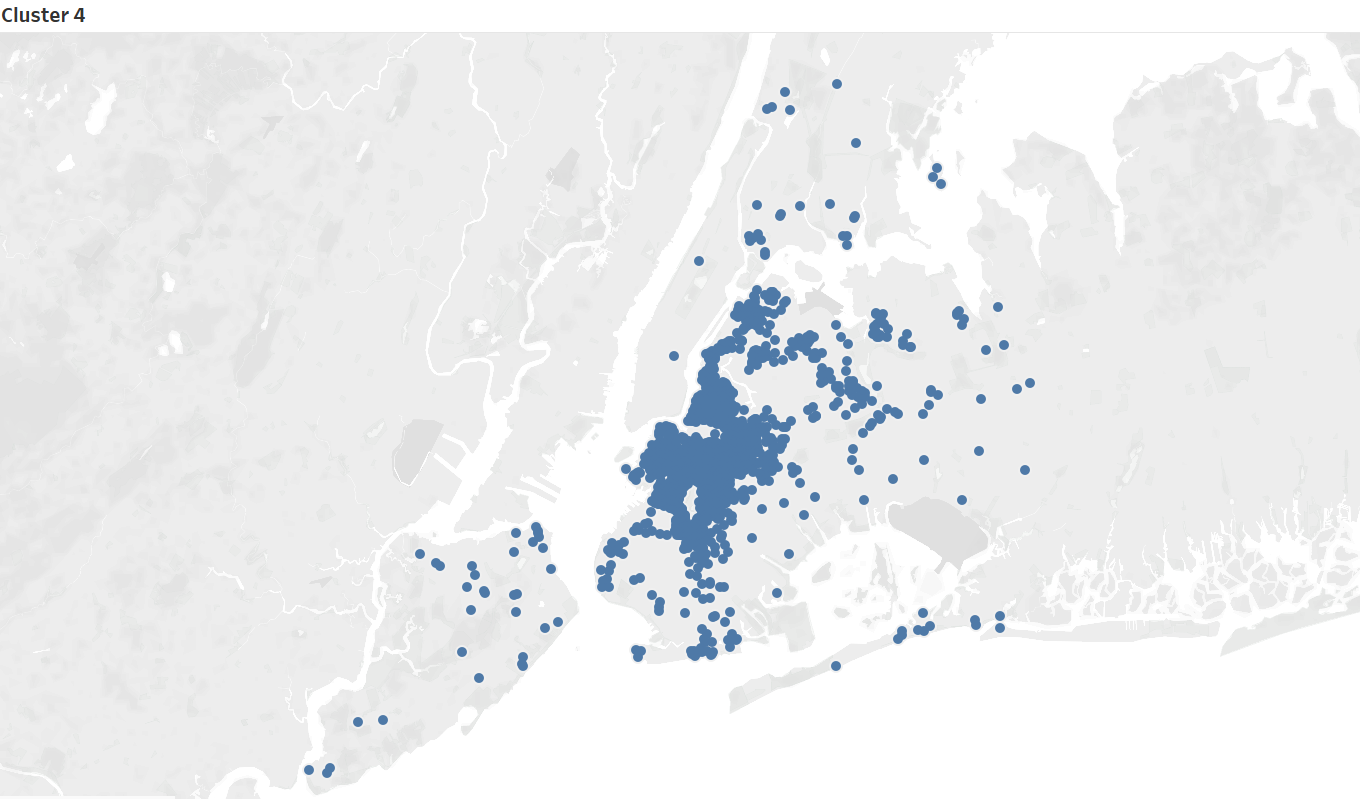

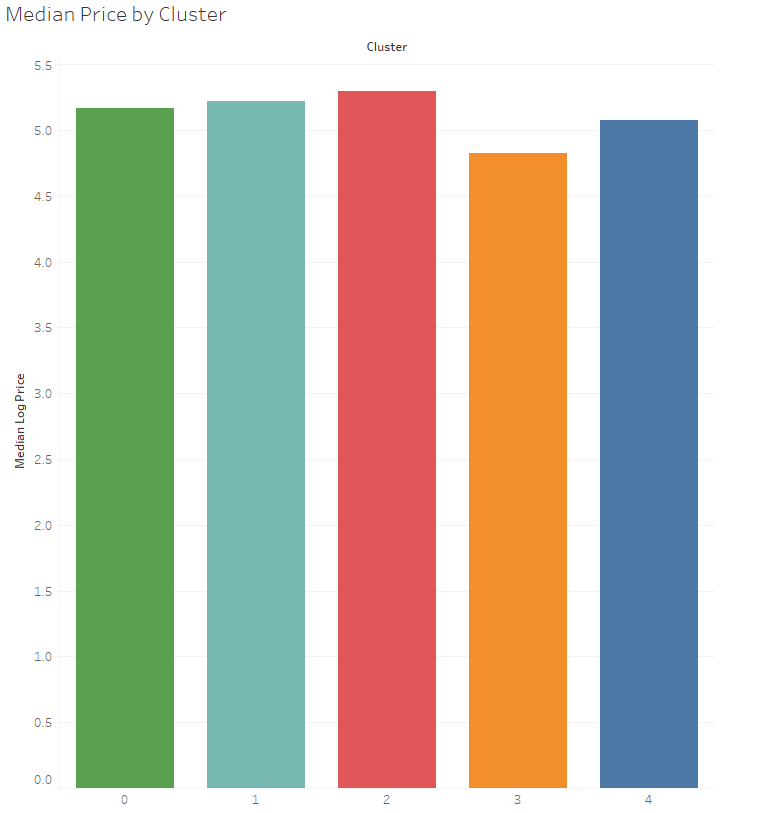

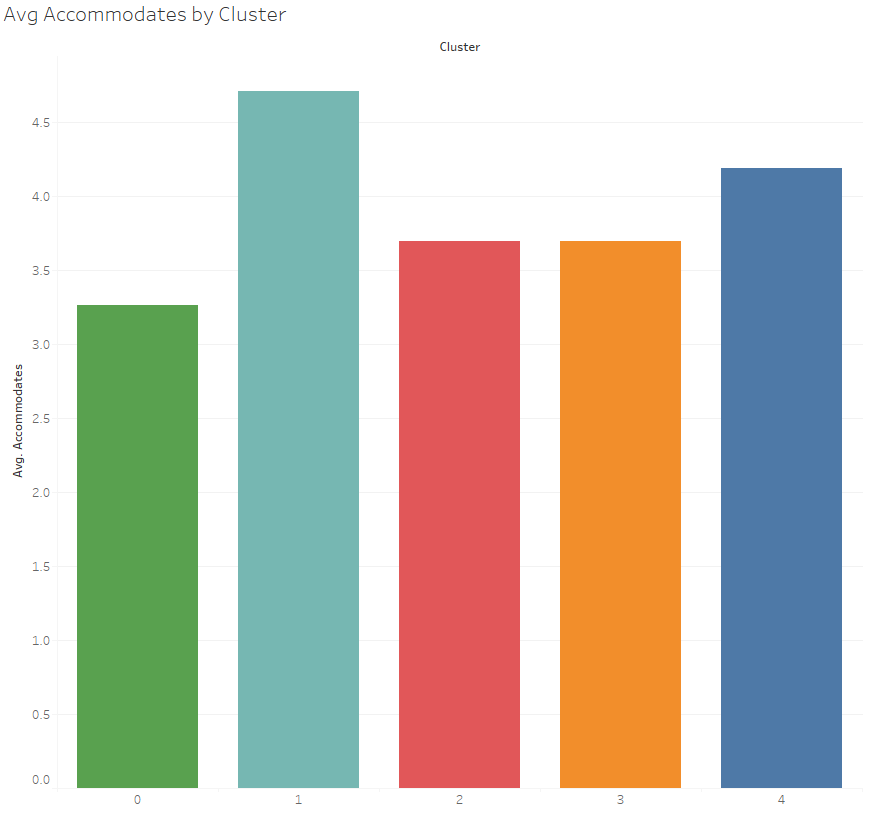

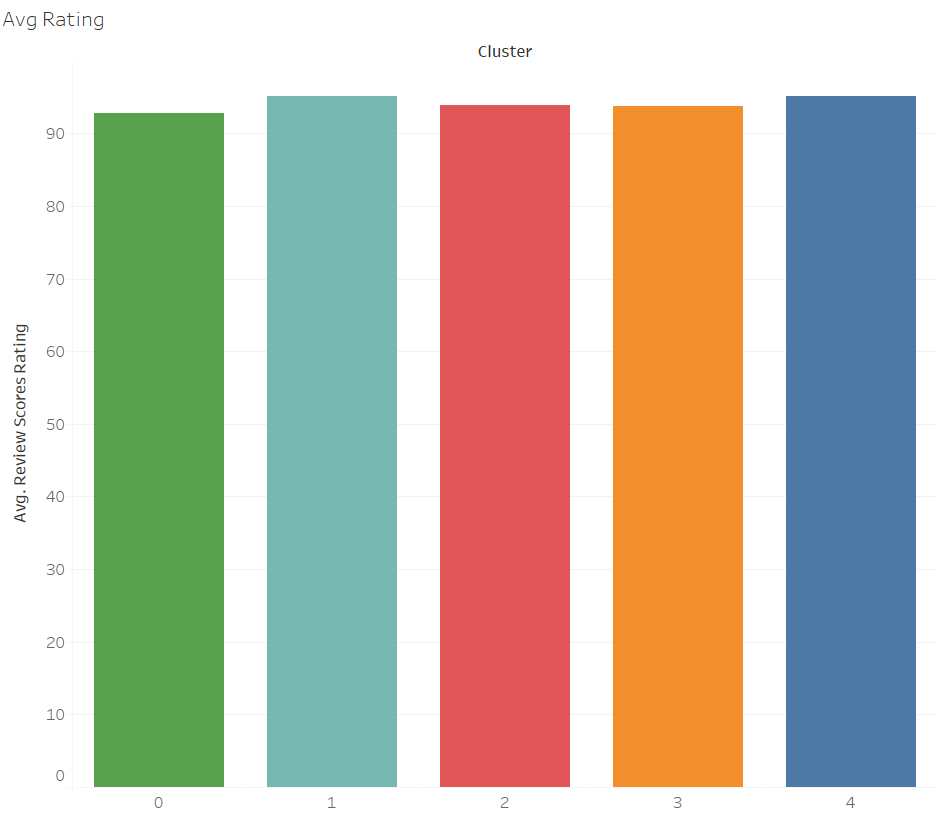

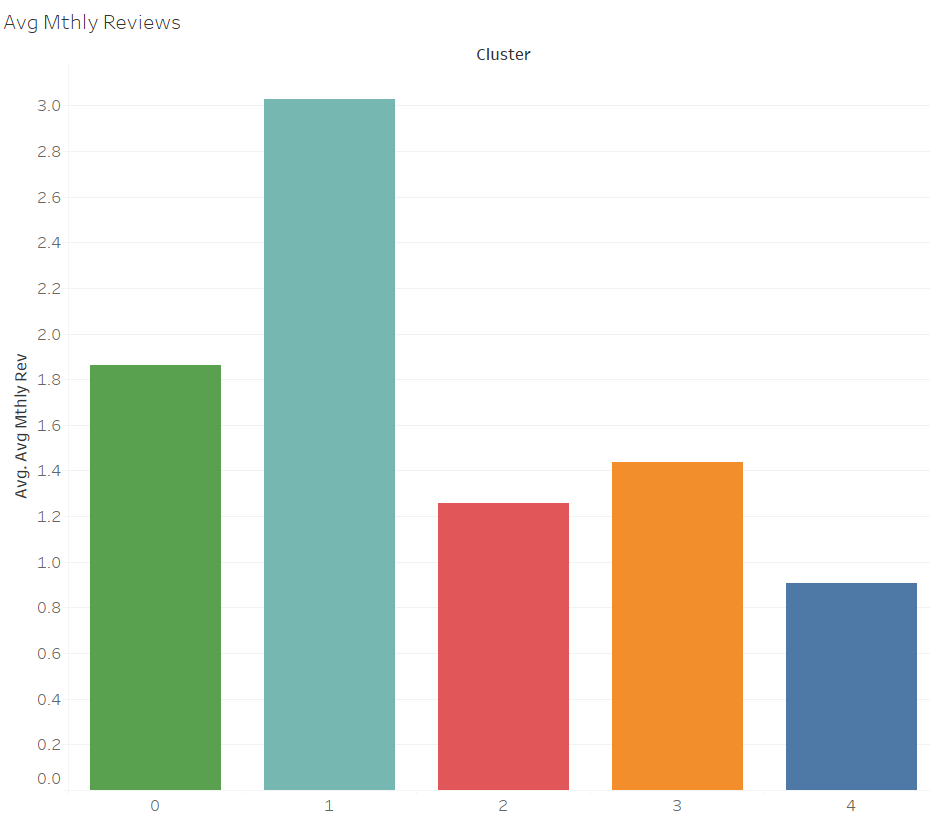

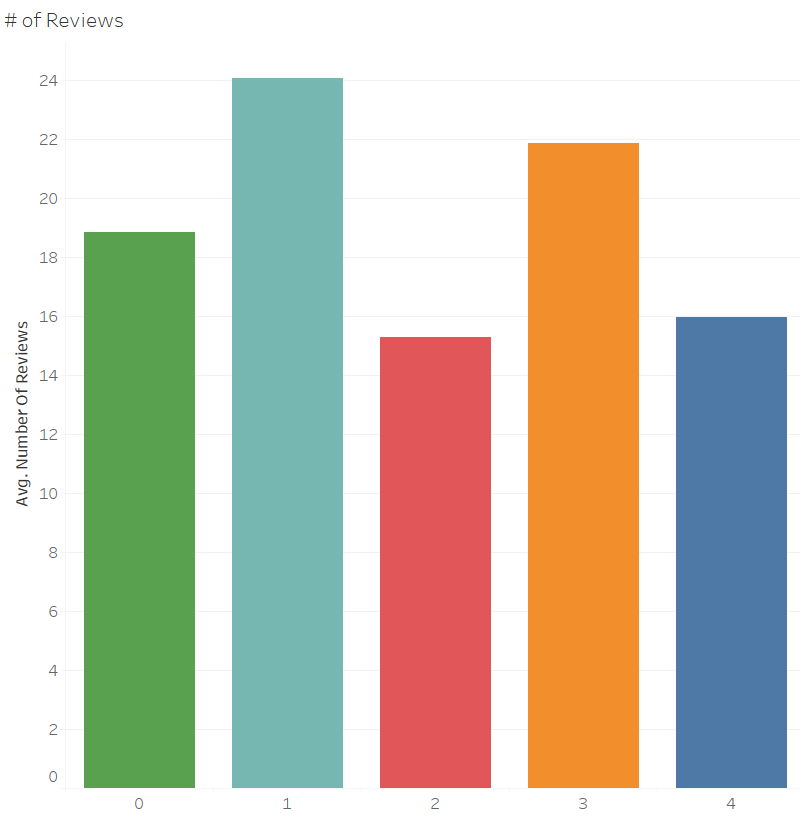

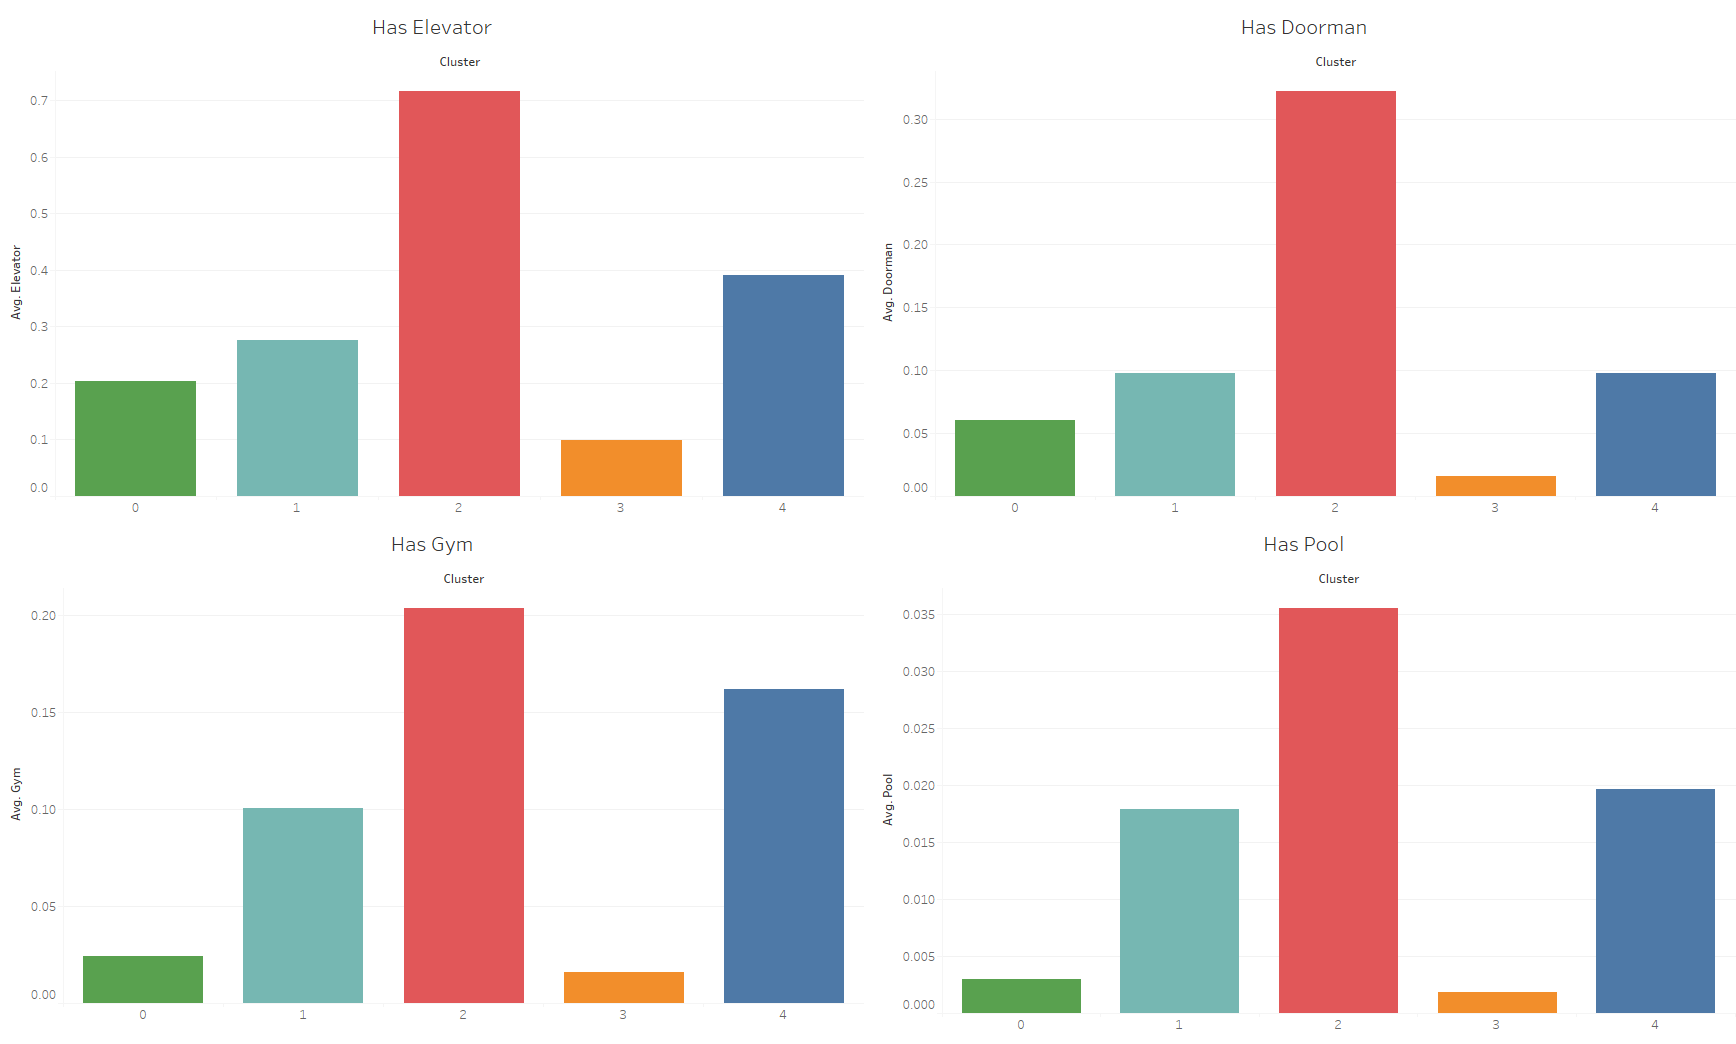

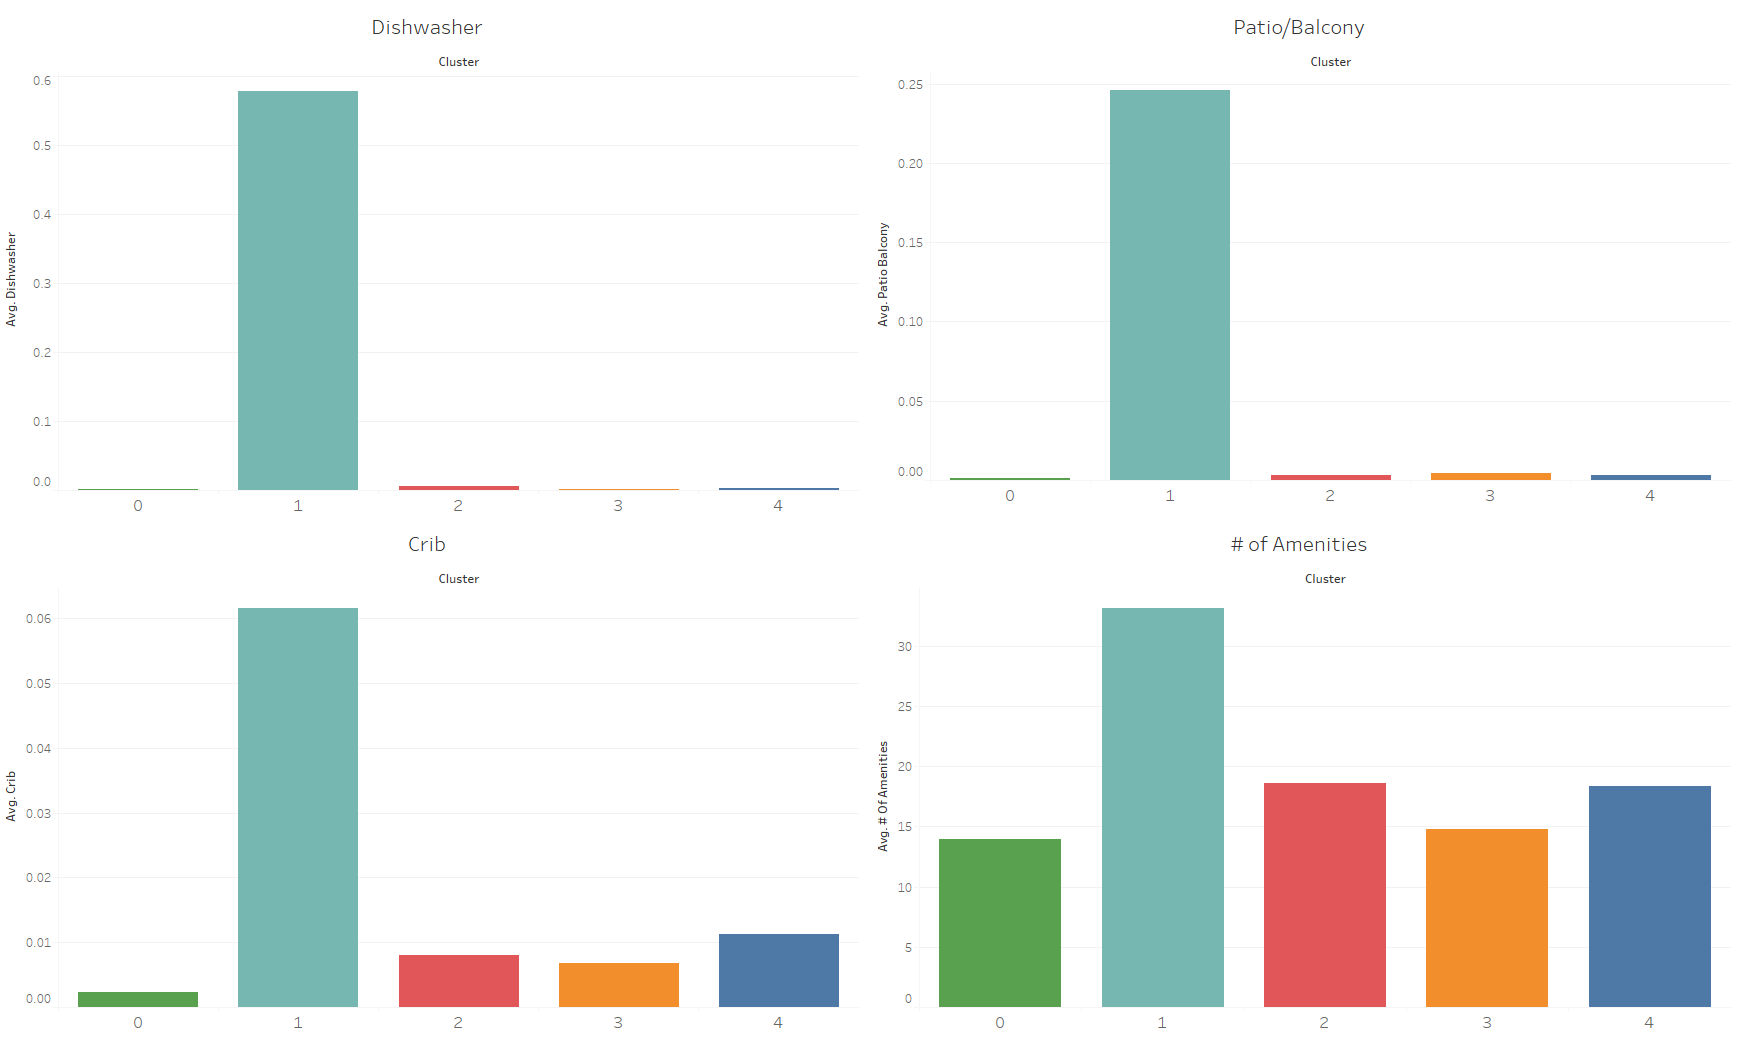

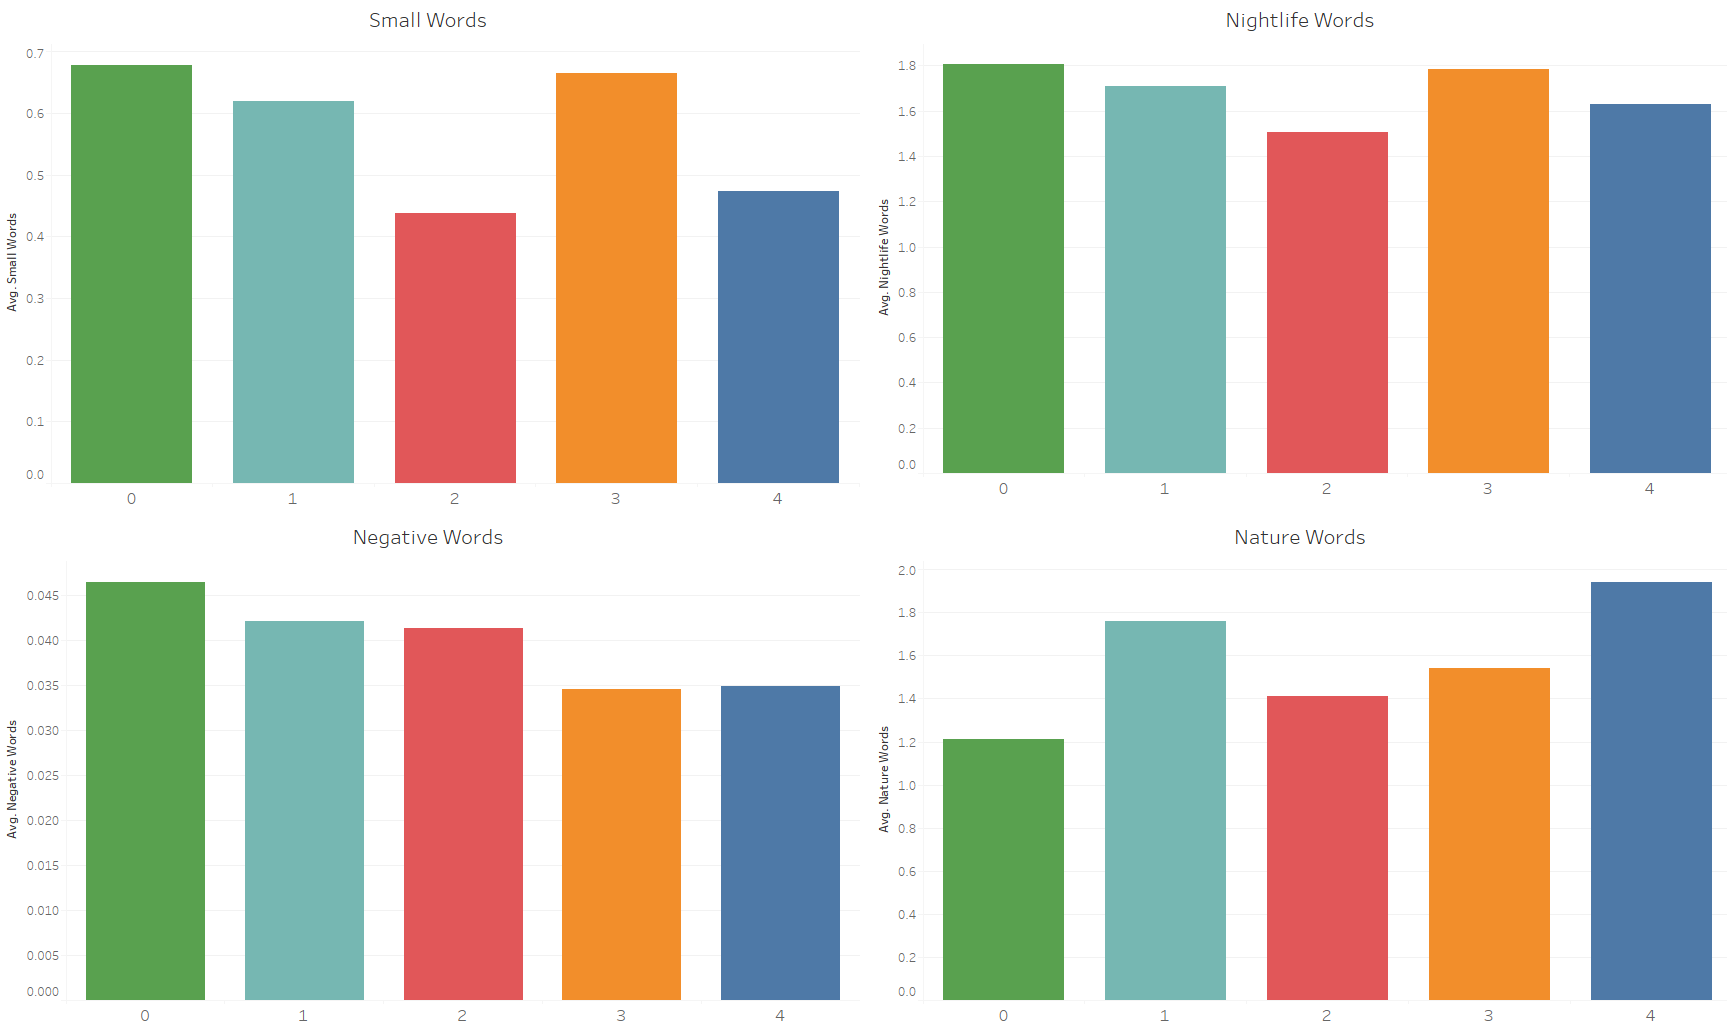

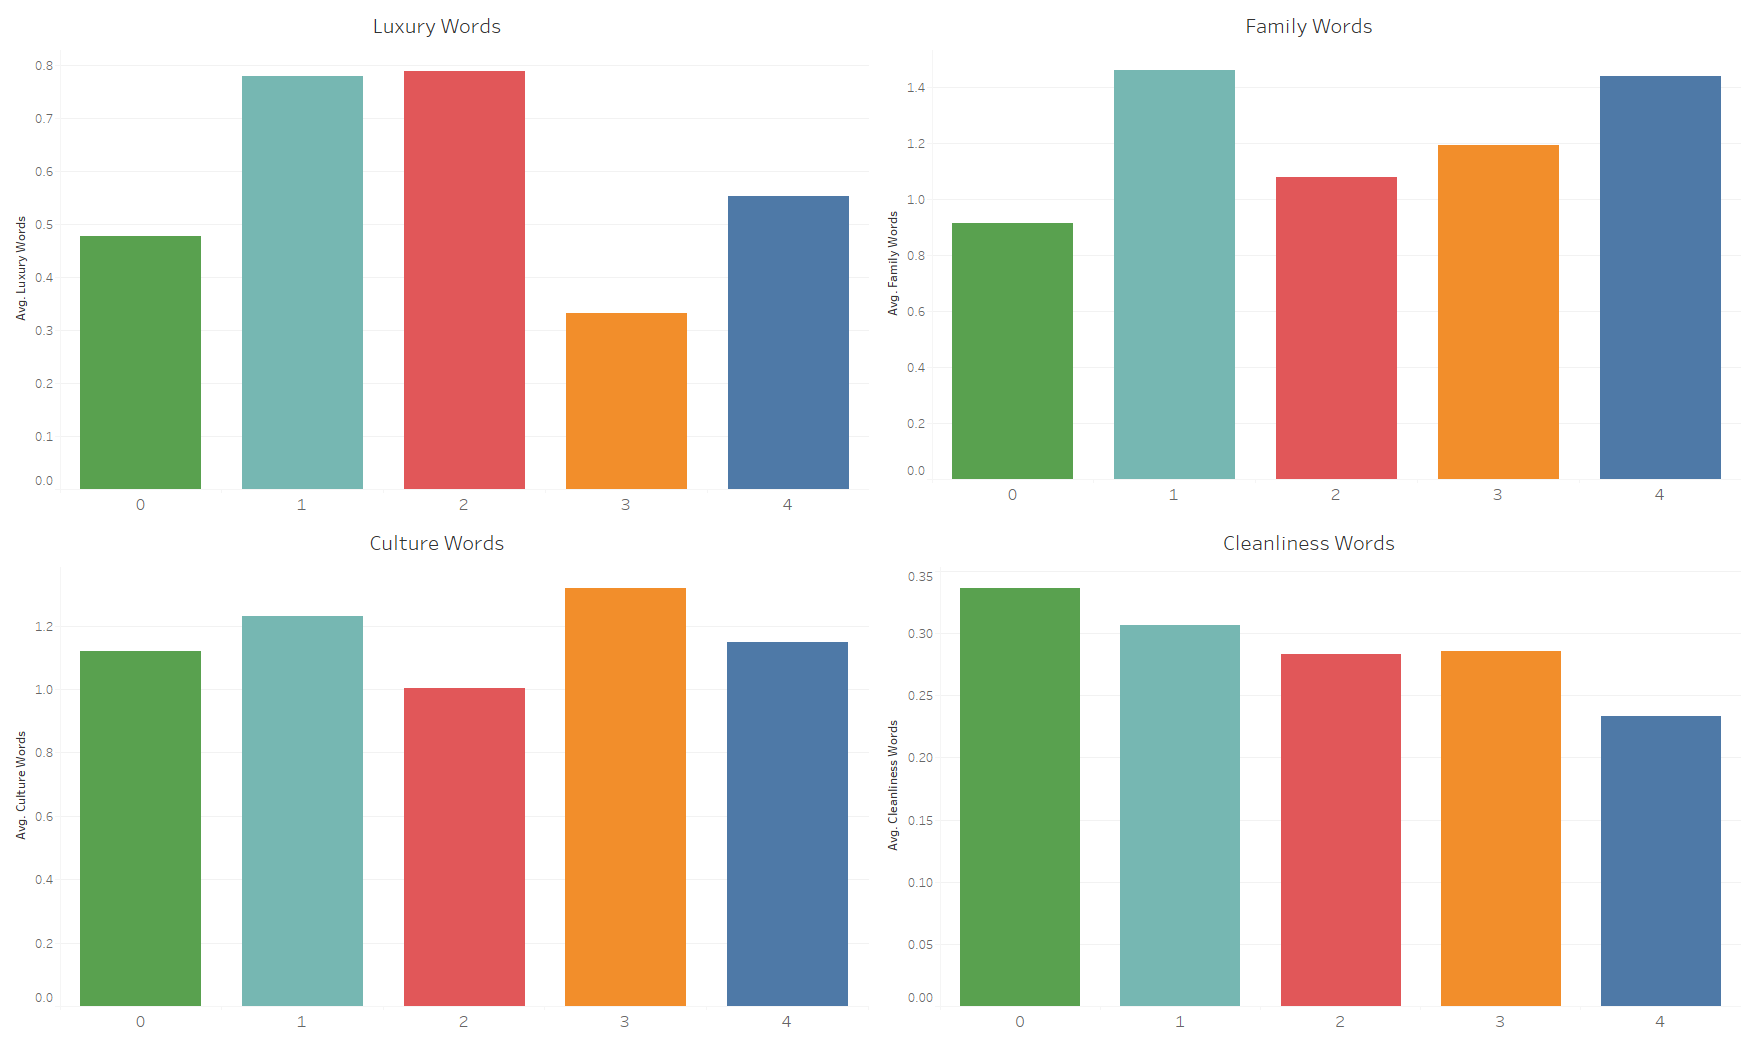

## Final Labeled Clusters

#### Cluster 0 - "Location Over Amenities"
- 99% Manhattan
- Last in # of amenities
- Last in Avg # Accommodated
- Least kid-friendly, least pet-friendly
- Middle of the pack on average price
- Most "small" words, "proximity" words, "nightlife" words, and "negative" words
- Fewest "nature" words, "family" words, and "safety" words

#### Cluster 1 - "Fully-loaded with Amenities"
- Geographically spread, well-represented in all 5 boroughs
- 1st in # of amenities by almost double
- Highest Avg # Accommodated
- Newest average listings
- Longest description lengths
- 10x or more leader in dishwashers, stoves/ovens, patios/balconies, 2x or more leader in another dozen amenity categories
- Most avg. reviews / month (best available proxy for occupancy rate)
- Most "updates" words, "family" words, "hip" words, "business" words, and "relaxation" words

#### Cluster 2 - "Luxury Manhattan"
- 98% Manhattan
- 1st in all 4 building-specific amenities: Elevators, doormen, pools, and gyms
- Highest average prices
- Smallest # of reviews
- Highest % of condos
- Best for wheelchair accessibility
- Most "luxury" words, "landmark" words, and "ease" words
- Fewest "public transit" words, "nightlife" words, "hip" words, "small" words

#### Cluster 3 - "Budget-friendly Outside Manhattan"
- 79% Brooklyn, 18% Queens
- Lowest average prices
- Lowest % Air Conditioned (still over 80%)
- Smallest cluster
- 2nd lowest avg # of amenities
- 2nd "oldest" listings (days since first review)
- Most "culture" words and "retail" words
- Fewest "updates" words and "luxury" words

#### Cluster 4 - "Premium Outside Manhattan"
- 86% Brooklyn, 11% Queens
- Most pet-friendly, most "pets on property"
- 2nd highest % of elevators, gyms, pools, wheelchair accessibility
- "Oldest" listings (days since first review)
- Highest # of lofts
- Fewest avg. reviews / month (best available proxy for occupancy rate)
- Most "view" words, "nature" words, 2nd most "family" words
- Fewest "landmark" words, "tourism" words, "proximity" words, and "ease" words


## Recommendations and Next Steps

A few recommendations I would give to Airbnb for them to leverage these new clusters:
- Clustering could perhaps be best leveraged by Airbnb's recommendation engine when used along with a user's historical rental behavior. If a user has shown a preference for properties that happen to fall within a certain cluster, search results could be tailored accordingly. This could even extend to cluster features instead of the clusters themselves. For example, if a user has shown a preference for staying outside a given city center but in larger, more well-appointed properties, Cluster 4 rentals could be slotted higher on that users search results for "NYC".
- Somewhat similar to the above, airbnb could allow its users to specify cluster-related preferences when they join that aid in recommendations. Some examples might include whether they're interested in relaxation or maximizing sightseeing opportunities, or whether they tend to travel as a couple, a family, or solo.
- It might also be advantageous to use these clusters to determine if owners are getting the most out of their descriptions by asking them if they want to include certain features common to their cluster. 
- Additionally, these results could help Airbnb identify owners whose rentals are over- or under-priced relative to the rest of their cluster.

And while the model performed well, here are some changes or additions I would recommend if Airbnb wanted to further improve the clustering:
- There are some additional rental data that could be useful to include if it exists, such as occupancy rate, and the full range of nightly rates for a property instead of simply an average.
- Tune and perform hierarchical clustering to see if it might show improved performance over KMeans
- Continue to grow the knowledge base of word groups by bringing in additional data. There are at least 11K more NYC rows in the Kaggle "Test" dataset which are only missing price.